# Failure detection of mechanical equipment - Pendulum Mills

### Implementation of Extended Isolaion Forest for anomaly and failure detection

### 1. Introduction:

One of the greatest challenges in heavy industry is detecting mechanical failures on time. By doing so, downtime can be reduced, equipment breakdowns can be avoided, and supply chain resilience can be increased.

"Condition based monitoring" is currently the most efficient way of detection - an ongoing, real-time monitoring of key performance metrics, such as vibrations, power consumption and temperature. The collected data is analyzed by machine learning and signal processing to assess the machine's health.

The challenge is not only detection, but the low tolerance of technicians towards false positives. A few "false alarms" can result in complete project redundancy as employees will lose faith in the reliability of the model and will ignore future alarms.

This project attempts to use data currently being monitored to identify mechanical failure, specifically on Pendulum mills (Further details can be found [here](https://www.neuman-esser.de//en/process/mills/pendulum-mills/#:~:text=The%20pendulum%20mill%20PM%20is,%2C%20quicklime%2C%20limestone%20and%20talc)).

### 2. Project goals:

1. Detect and alert on failure.
2. Avoid false alarms (False Positive). According to the client, 20 days with false positive alarms per calendric year is acceptable.

### 3. General settings and utility Functions

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import skew
from scipy import fftpack
from tqdm import tqdm
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator

In [5]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (40, 20)

In [6]:
#Read Raw Data:
data = pd.read_csv(r'C:\Users\Evia\Downloads\Raw Data.csv')
#data = pd.read_csv(r'C:\Users\eviatar_b\Downloads\IEF\Plant 41\Raw Data.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.columns = ['Date&Time', 'Vibrations', 'Current']
data['Date&Time'] = pd.to_datetime(data['Date&Time'])
data.drop_duplicates(subset=['Date&Time'], inplace = True)

In [7]:
def axis_label(data, interval = 2160):
    x_axis_interval = np.arange(0, len(data), interval)
    x_axis_labels = data['Date&Time'].dt.strftime('%yyyy-%MM-%dd %hh:%mm:%ss').iloc[x_axis_interval].str[5:16]
    plt.xticks(x_axis_interval, x_axis_labels, rotation = 90);
    
    return x_axis_interval, x_axis_labels

In [8]:
def compute_fft(arr):
    
    npnts = len(arr)
    sr = 1/5             #sample rate
    
    sig_fft = fftpack.fft(arr)
    
    amp = 2*np.abs(sig_fft)/npnts
    freq = fftpack.fftfreq(npnts, sr)
    
    fft = np.append(freq.reshape(-1,1), amp.reshape(-1,1), axis = 1)
    
    return fft[fft[:,0] >=0]

### 4. Data Description
The data set consist of 2 signals, over one year period (1.4.2021-31.3.2022).
There are 3 features in the dataset:

1. Time and time stamp
2. Current signal - Percentage of maximum power allowed by the motor.
3. Vibration signal - The magnitude of velocity [mm/s], measured by the sensor, perpendicular to the machine. 

### 4.1 Sample rate:

The sampling rates of the signals are not constant. Each sample is logged only if the difference between the previous data point passes a certain threshold (memory wise issue) and usually occur around every 30 seconds.
To align the time stamps and not lose important data, I up sampled the data to 5 second intervals with linear interpolation.

### 4.2 Data overlook, handling missing values

In [9]:
data.head()

Date&Time  Vibrations    Current
0 2021-04-01 00:00:00   10.493015  80.325895
1 2021-04-01 00:00:05   10.902379  79.503802
2 2021-04-01 00:00:10   11.311743  78.283063
3 2021-04-01 00:00:15   11.721107  77.660797
4 2021-04-01 00:00:20   12.130472  77.637004

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6306480 entries, 0 to 6307199
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date&Time   datetime64[ns]
 1   Vibrations  float64       
 2   Current     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 192.5 MB


In [11]:
data.describe()

Vibrations       Current
count  6.305396e+06  6.305395e+06
mean   7.133402e+00  6.167660e+01
std    3.736805e+00  3.043297e+01
min    0.000000e+00  1.410106e+00
25%    5.326415e+00  6.554488e+01
50%    7.104657e+00  7.656705e+01
75%    9.266754e+00  7.987396e+01
max    5.181978e+01  1.557467e+02

###### Missing values:

In [12]:
data.isnull().sum()

Date&Time        0
Vibrations    1084
Current       1085
dtype: int64

Since less than 0.03% of data, I set them to 0. Most likely the sensors were offline for maintenance.

In [13]:
data.fillna(0, inplace = True)

### 5. Known failures:

There is no specific log of failures over the years, which is why it is an unsupervised problem.
However, over the past year, 2 major failures occurred - at the 17-18.2.2022 and 9-10.3.2022. We will use this knowledge to assess the detection quality of the model.

Figs 5.1 and 5.2 plot the current signal (red line) and the vibration signal (blue line) readings of February and March failure. The darker background is the failure time window.

Note that although a significant change can be observed in the signals, the machine continues to work for **several hours without detection**.

In [14]:
data['fail'] = 0
fail_idx_feb = np.where((data['Date&Time'] > '2022-02-17 12:00:00') & (data['Date&Time'] < '2022-02-18 10:30:00'))
fail_idx_mar = np.where((data['Date&Time'] > '2022-03-09 07:30:00') & (data['Date&Time'] < '2022-03-10 08:30:00'))
data.loc[fail_idx_feb[0], 'fail'] = 1
data.loc[fail_idx_mar[0], 'fail'] = 1

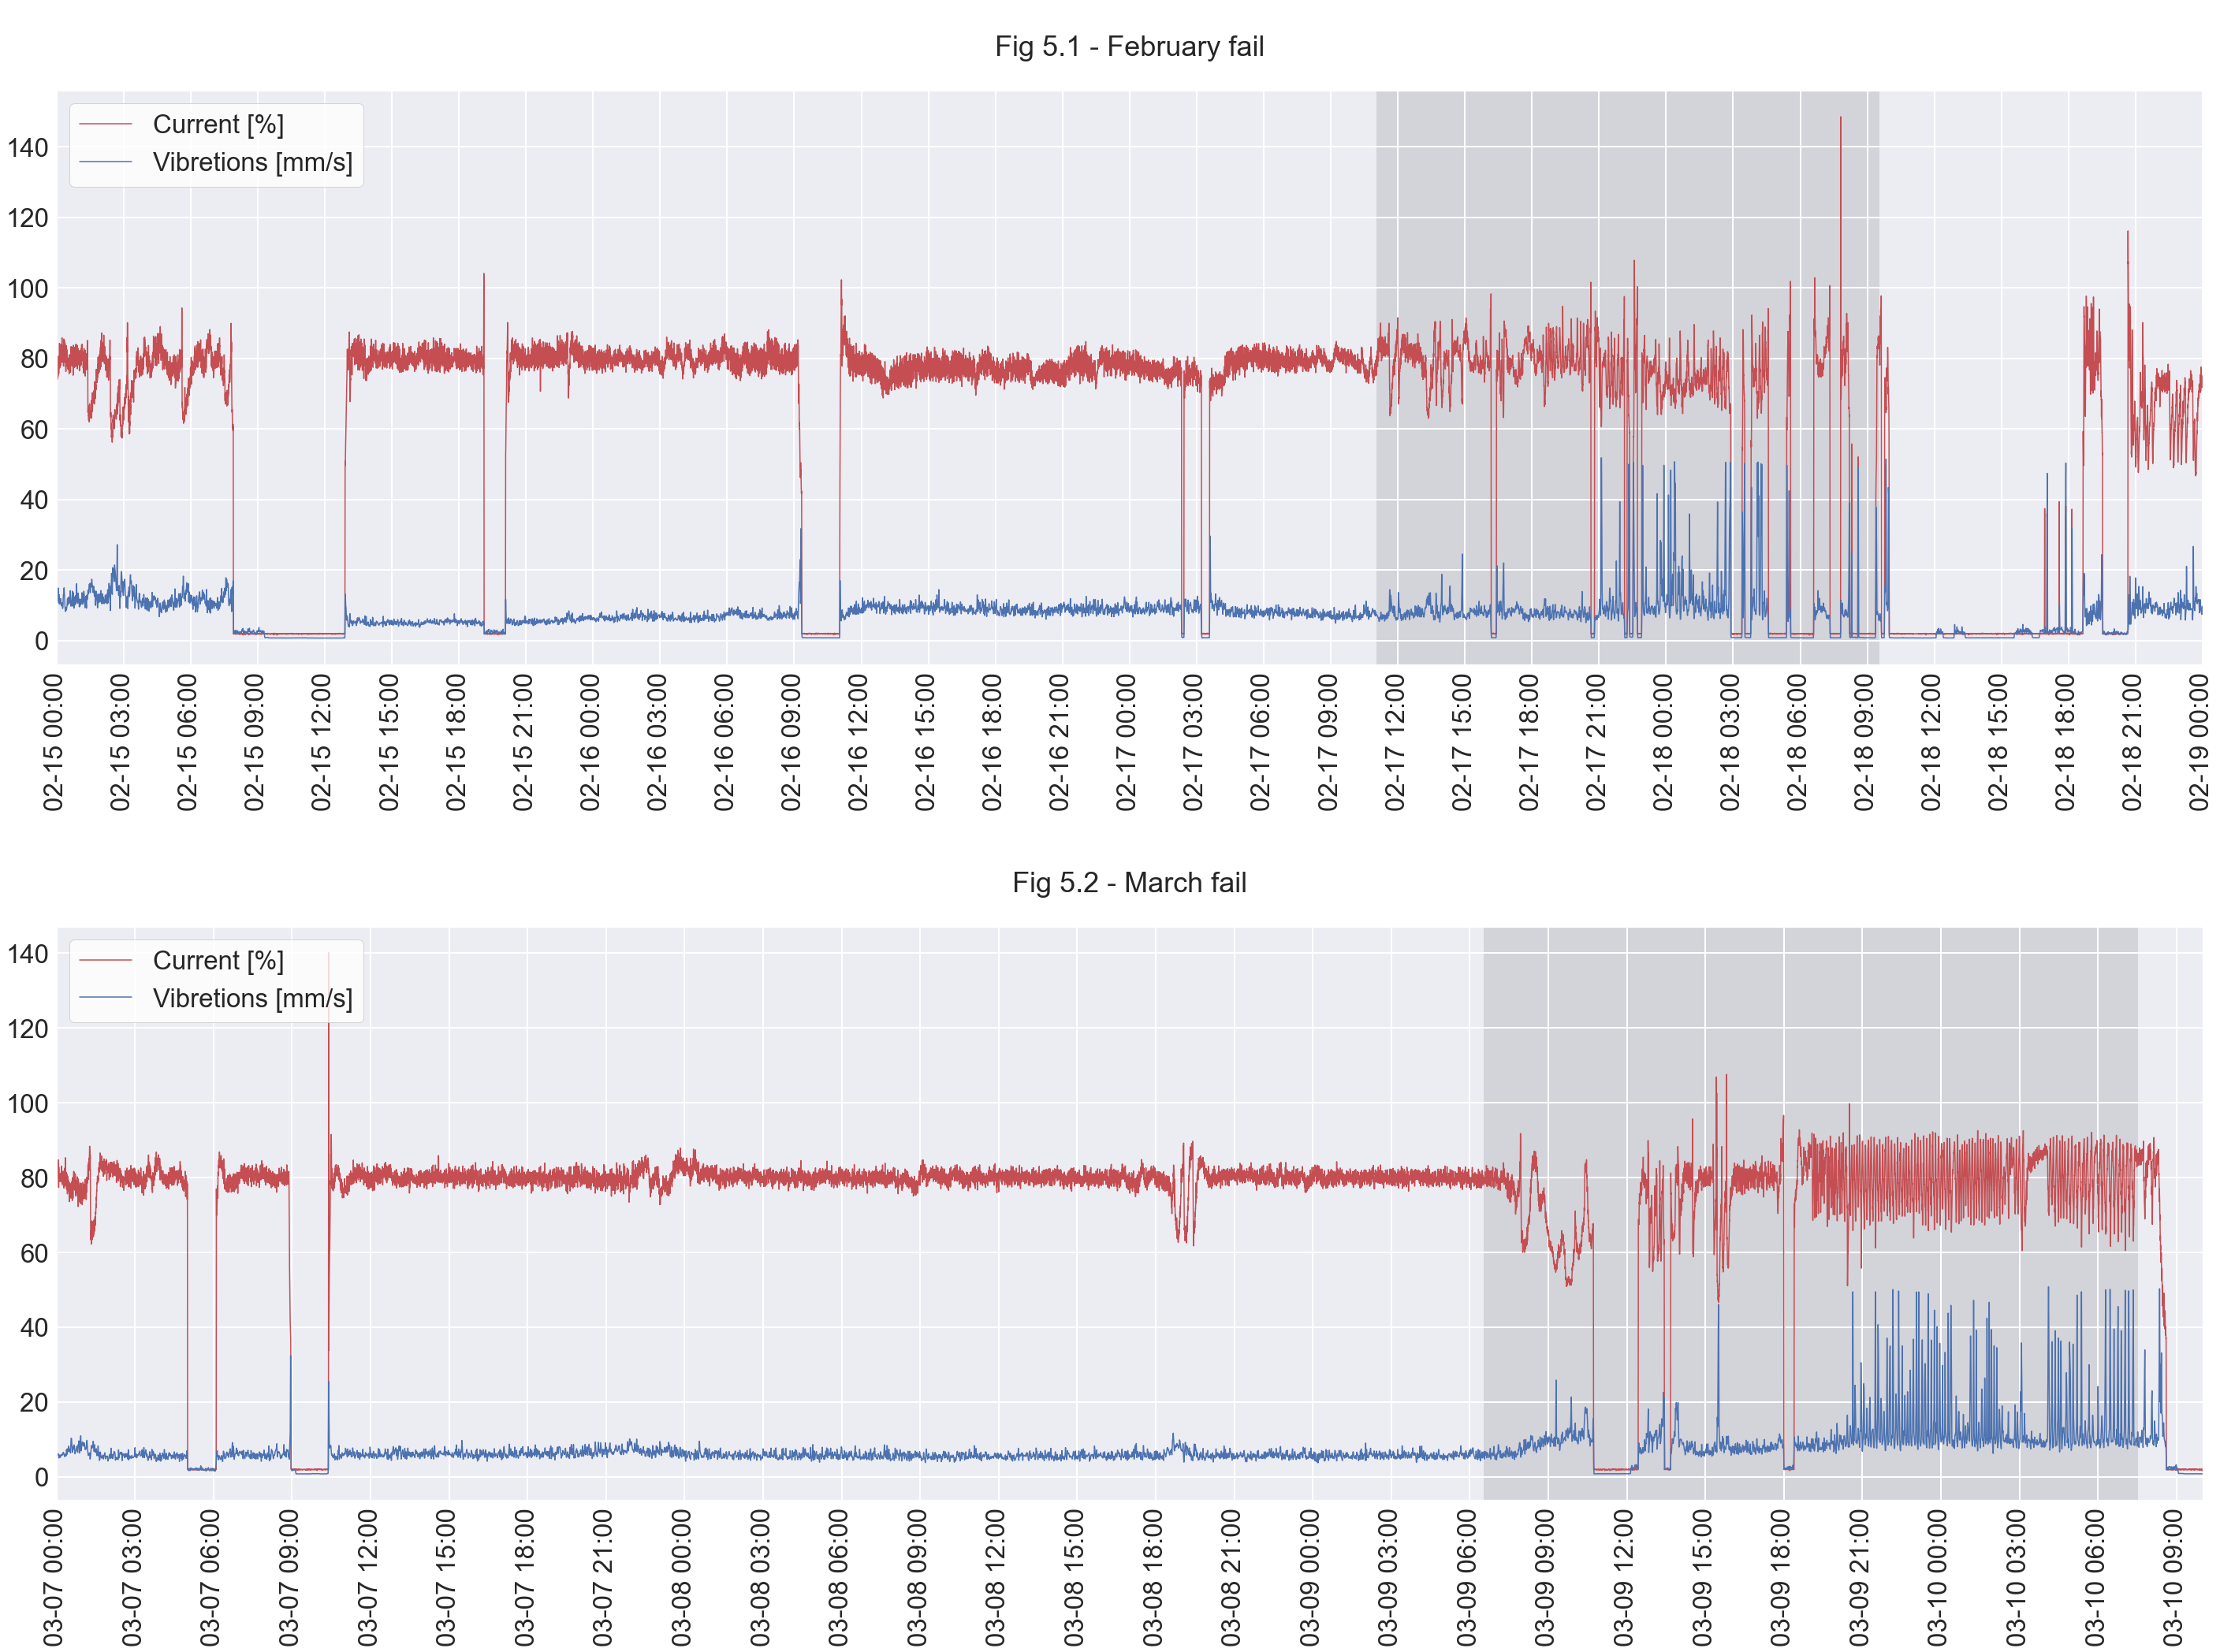

In [15]:
sns.set_theme(font_scale = 3) 

data_feb = data[(data['Date&Time'] >= '2022-02-15 00:00:00') & (data['Date&Time'] <= '2022-02-19 00:00:00')]
data_mar = data[(data['Date&Time'] >= '2022-03-07 00:00:00') & (data['Date&Time'] <= '2022-03-10 10:00:00')]

fig = plt.figure(figsize=(40, 30))
ax1 = fig.add_subplot(211)

p = sns.lineplot(data = data_feb, x = np.arange(0,len(data_feb)) , y = 'Current', color = 'r', label = 'Current [%]', ax = ax1)
p = sns.lineplot(data = data_feb, x = np.arange(0,len(data_feb)) , y = 'Vibrations', color = 'b', label = 'Vibretions [mm/s]', ax = ax1)
plt.grid(linewidth=2, color = 'white', alpha = 1)
axis_label(data_feb);
ax1.set_ylabel('')

plt.xlim(0,len(data_feb))
plt.legend(loc = 'upper left', facecolor = 'white')
plt.title('\nFig 5.1 - February fail\n')
ax1.pcolorfast(p.get_xlim(), p.get_ylim(),
      data_feb['fail'].values[np.newaxis],
      cmap='binary', alpha=0.1);

ax2 = fig.add_subplot(212)

p = sns.lineplot(data = data_mar, x = np.arange(0,len(data_mar)) , y = 'Current', color = 'r', label = 'Current [%]', ax = ax2)
p = sns.lineplot(data = data_mar, x = np.arange(0,len(data_mar)) , y = 'Vibrations', color = 'b', label = 'Vibretions [mm/s]', ax = ax2)
plt.grid(linewidth=2, color = 'white', alpha = 1)
axis_label(data_mar);
ax2.set_ylabel('')
plt.xlim(0,len(data_mar))

plt.legend(loc = 'upper left', facecolor = 'white')
plt.title('\nFig 5.2 - March fail\n')
ax2.pcolorfast(p.get_xlim(), p.get_ylim(),
      data_mar['fail'].values[np.newaxis],
      cmap='binary', alpha=0.1);

plt.tight_layout()

### 6. Feature exploration and extraction:

Feature exploration (and extraction later) are relevant only for time frames where the machine is online, which is why I filter rows where Current < 50%.

In [16]:
data_online = data[data['Current'] > 50].copy().reset_index(drop = True)

### 6.1 Current:

The distribution in fig 6.1 suggest that normal readings range from 60% to 90%~. Higher readings can suggest abnormal behavior.

However, strong oscillations can also point to abnormal behavior, as can be seen in figures 5.1 and 5.2. Although the signal oscillates around 80%, the amplitude of the signal increases during failure from 75% - 85% to 65% - 90%.

The amplitude increase over time is important to distinguish. To do so, we must extract new features.

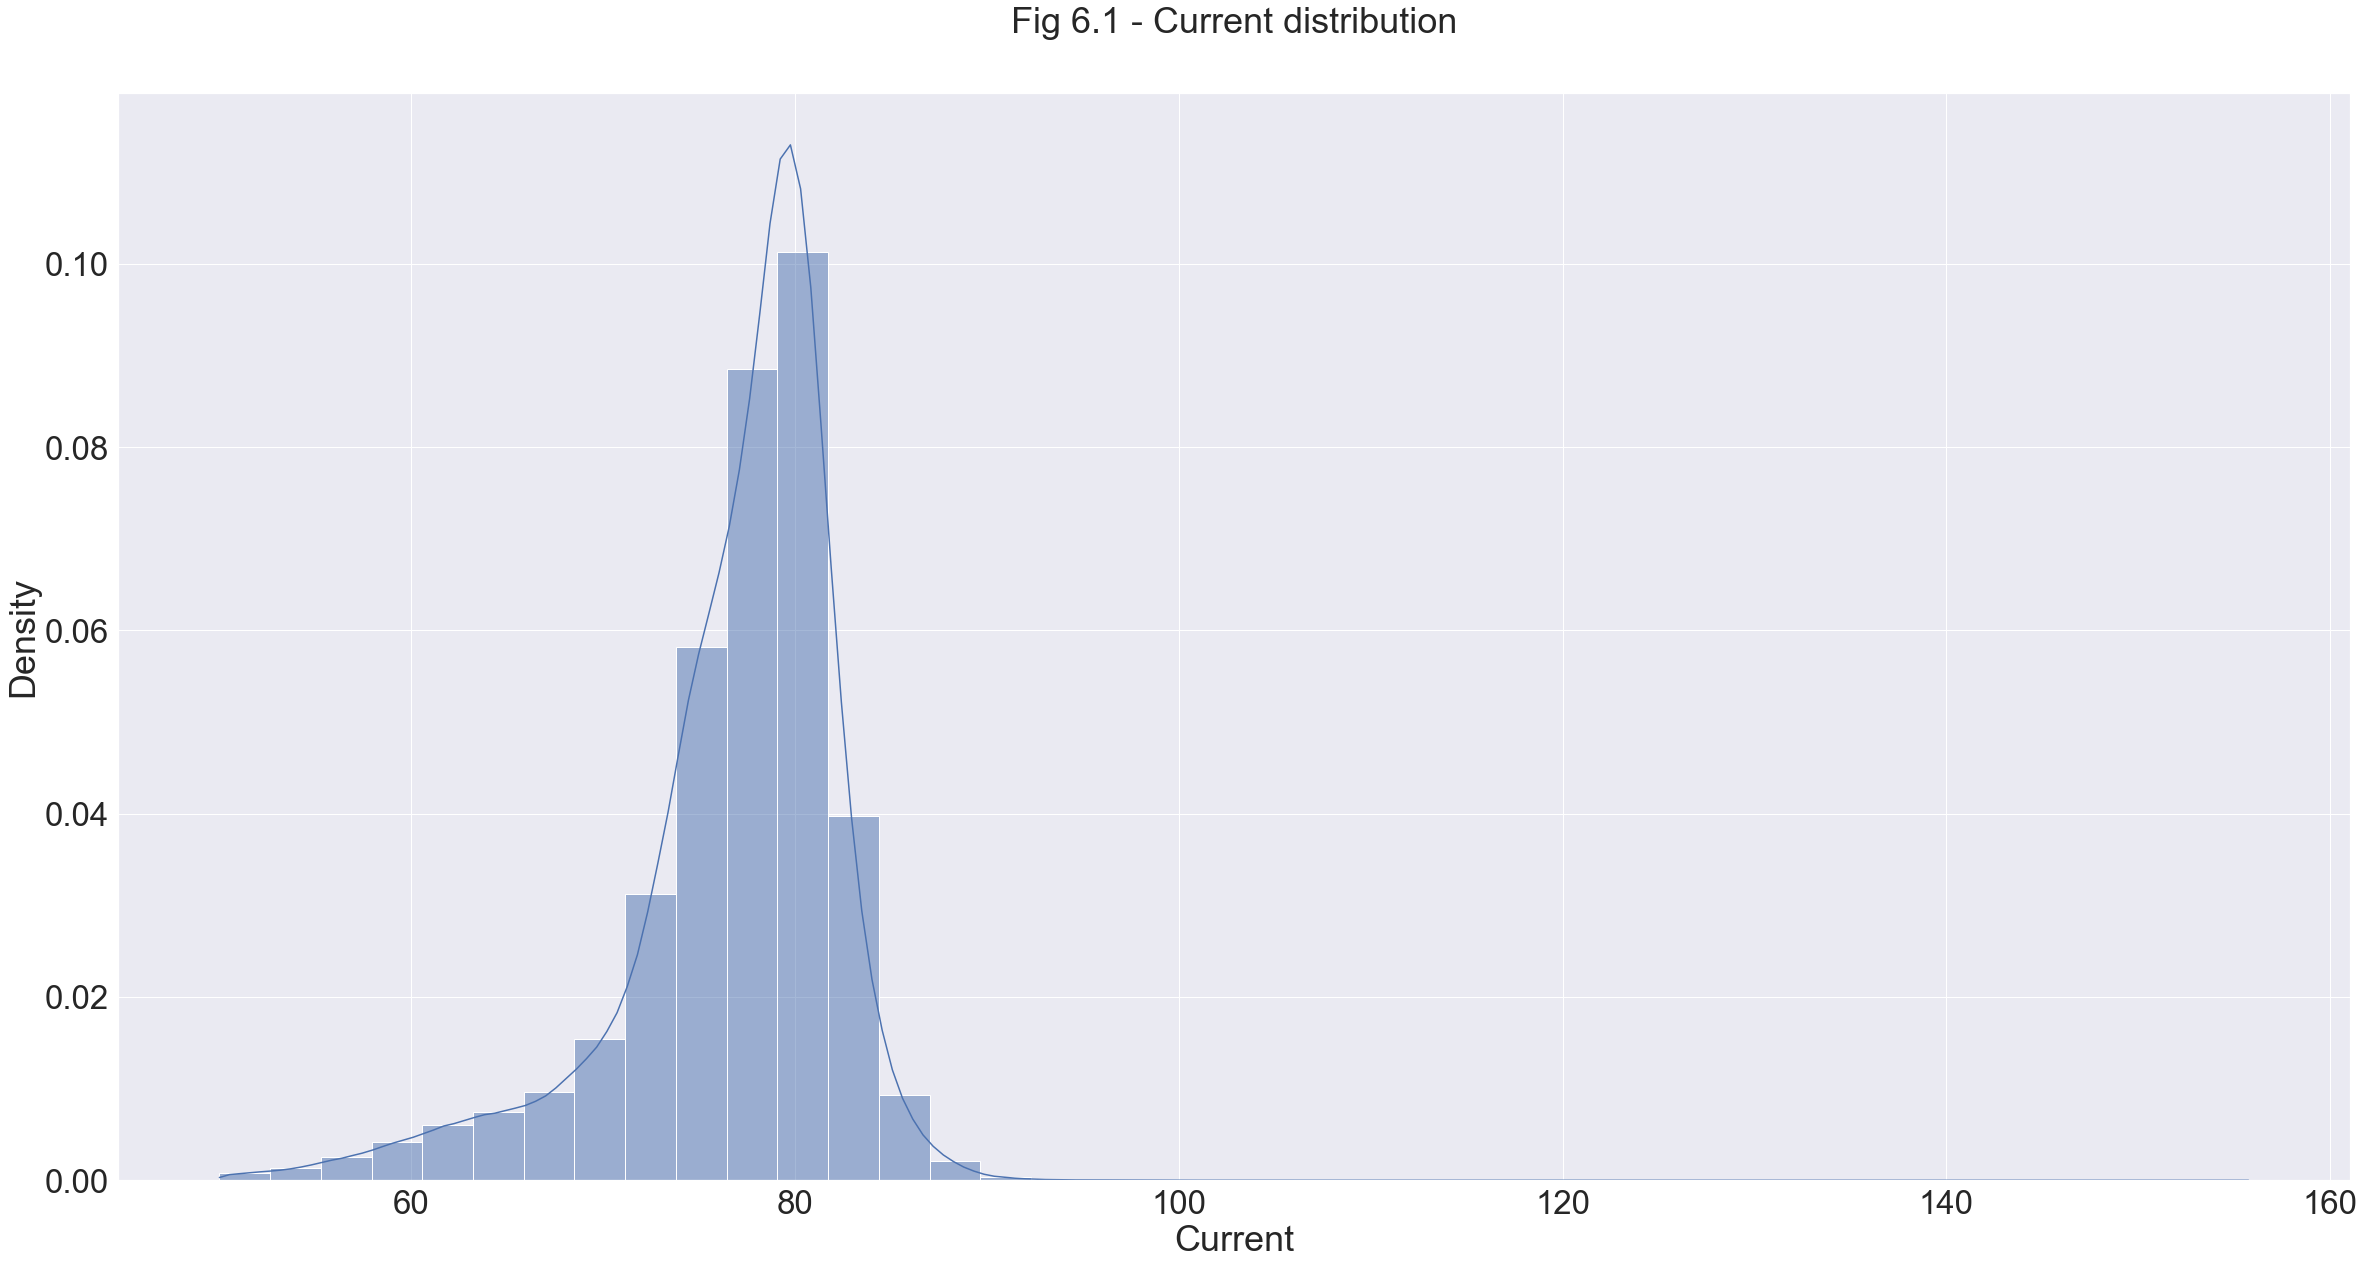

In [17]:
sns.set_theme(font_scale = 3) 
sns.histplot(x = data_online['Current'], bins = 40, kde = True, stat = 'density')
plt.title('Fig 6.1 - Current distribution', y = 1.05);

### 6.2 Feature extraction - Fourier Transformation

Fourier transformation transforms signals from the time domain to frequency domain.

The transformation allows detection of frequencies with higher power, which should not occur during normal operation and can therefore be regarded as abnormal.

Figure 6.2.1 illustrate the difference in FFT between normal and abnormal behavior.

In [18]:
#Setting 1 hour window length
window = 720

#Mirroring the first and last 360 rows of data to remove edge effects:
crnt_median = pd.concat([data_online['Current'].iloc[:int(window/2)][::-1],
                         data_online['Current'],
                         data_online['Current'].iloc[len(data_online)-int(window/2):][::-1]])

#Calculating Current median:
crnt_median = crnt_median.rolling(window = window+1, center = True).median()
crnt_median.dropna(inplace = True)

#Detrending Current with median:
data_online['detrend_crnt'] = data_online['Current'] - crnt_median
del crnt_median

In [19]:
data = data.merge(data_online[['Date&Time', 'detrend_crnt']] , on = 'Date&Time', how = 'left')
data.fillna(0, inplace = True)

In [20]:
data.head()

Date&Time  Vibrations    Current  fail  detrend_crnt
0 2021-04-01 00:00:00   10.493015  80.325895     0      1.709752
1 2021-04-01 00:00:05   10.902379  79.503802     0      0.887660
2 2021-04-01 00:00:10   11.311743  78.283063     0     -0.333079
3 2021-04-01 00:00:15   11.721107  77.660797     0     -0.955345
4 2021-04-01 00:00:20   12.130472  77.637004     0     -0.979139

###### FFT Visualization:

In [21]:
#abnormal signal - taken from current, during march failure
data_abnormal = data['detrend_crnt'][(data['Date&Time'] > '2022-03-09 21:00:00') & (data['Date&Time'] < '2022-03-09 21:30:00')].values

#normal signal - taken from current, before march failure
data_normal = data['detrend_crnt'][(data['Date&Time'] > '2022-03-09 00:00:00') & (data['Date&Time'] < '2022-03-09 00:30:00')].values

In [22]:
data_mar = data[(data['Date&Time'] >= '2022-03-08 21:00:00') & (data['Date&Time'] <= '2022-03-10 10:00:00')]

#get index of the first row of data_mar:
start_index = data[data['Date&Time'] == '2022-03-08 21:00:00'].index.values.astype(int)[0]

#get index of start and end of data_abnormal:
abnormal_start = data[data['Date&Time'] == '2022-03-09 21:00:00'].index.values.astype(int)[0]-start_index
abnormal_end = abnormal_start + 360

#get index of start and end of data_normal:
normal_start = data[data['Date&Time'] == '2022-03-09 00:00:00'].index.values.astype(int)[0]-start_index
normal_end = normal_start + 360

backround = np.array([0]*len(data_mar))
backround[abnormal_start:abnormal_end] = 2
backround[normal_start:normal_end] = -2

Plot FFT of normal and abnormal current behaviour

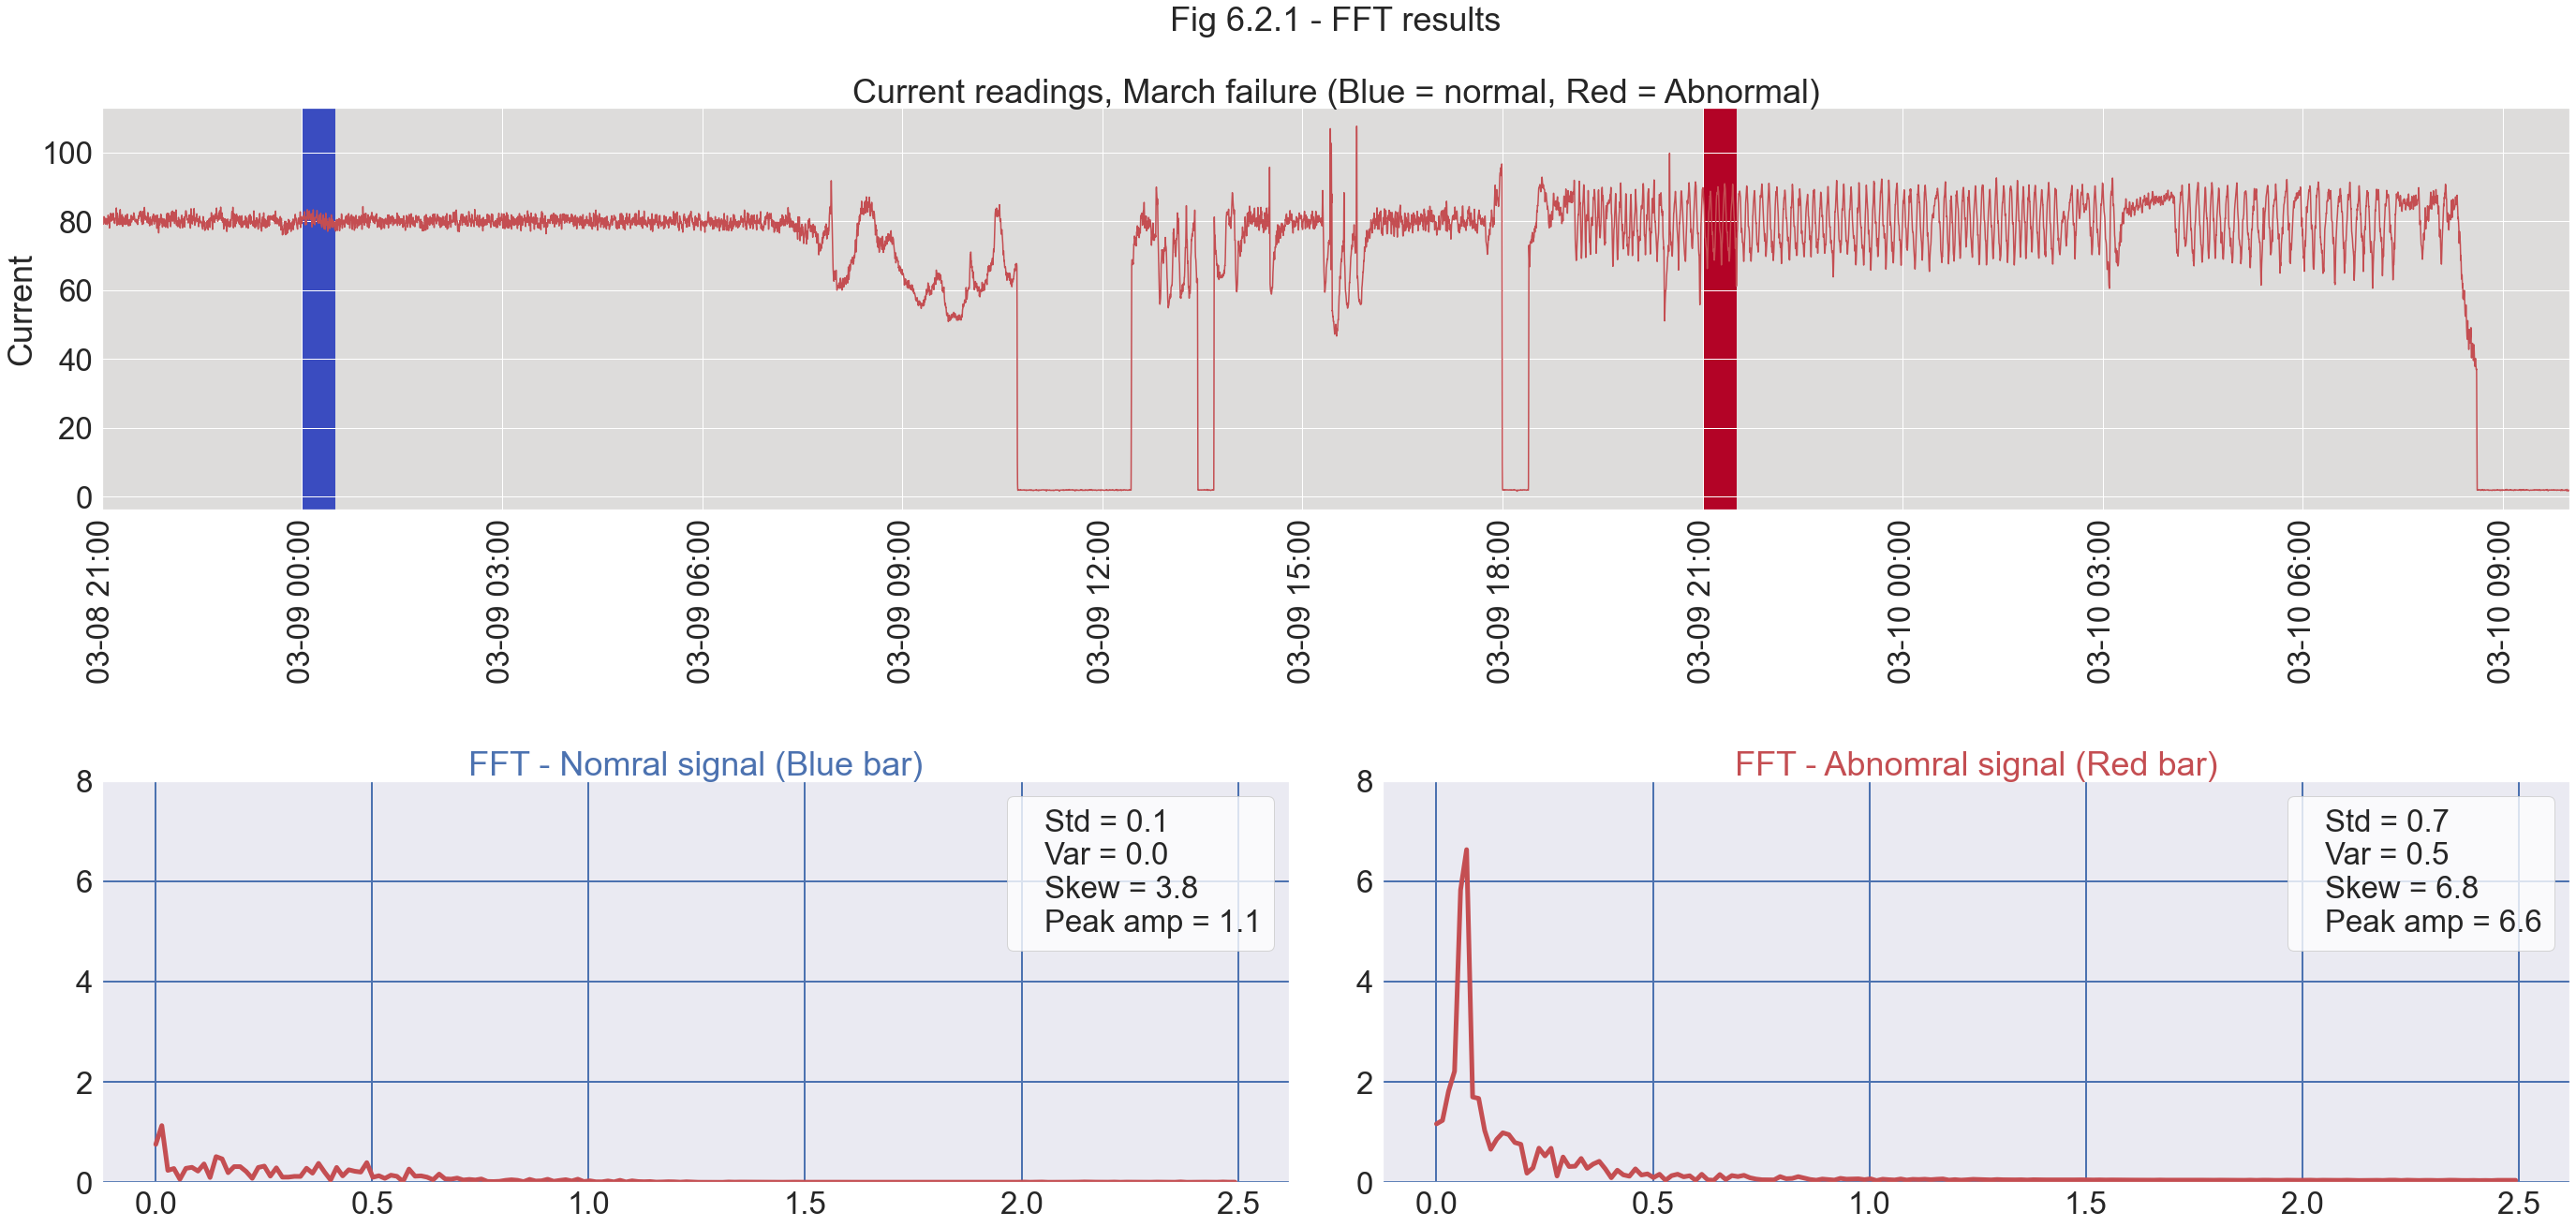

In [23]:
sns.set_theme(font_scale = 3) 

fig, ax = plt.subplots(2, 2)
ax = ax.flatten()

#First plot - raw signal
ax[0] = plt.subplot2grid(shape = (2,2), loc = (0,0), colspan=2)

p = sns.lineplot(data = data_mar, x = np.arange(0,len(data_mar)) , y = 'Current', color = 'r', ax = ax[0])
plt.xlim(0, len(data_mar))
p.pcolorfast(p.get_xlim(), p.get_ylim(),
      backround[np.newaxis],
      cmap='coolwarm', alpha=1)

axis_label(data_mar)
plt.title('Fig 6.2.1 - FFT results\n\nCurrent readings, March failure (Blue = normal, Red = Abnormal)')

#second plot - FFT on normal signal
ax[1] = plt.subplot2grid(shape = (2,2), loc = (1,0), rowspan=1)

fft = compute_fft(data_normal)

std = round(np.std(fft[:,1]), 1)
var = round(np.var(fft[:,1]), 1)
skewness = round(skew(fft[:,1]), 1)
peak = round(fft[:,1].max(), 1)

label = f'Std = {std}\nVar = {var}\nSkew = {skewness}\nPeak amp = {peak}'

sns.lineplot(x = fft[:, 0] , y = fft[:, 1], color = 'r', ax = ax[1], lw = 5, label = label)
plt.ylim(0, 8)
plt.title('FFT - Nomral signal (Blue bar)', color = 'b')
plt.grid(linewidth=2, color = 'b', alpha = 1)
plt.legend(handlelength=0, facecolor = 'white')

#Third plot - FFT on abnormal signal
ax[2] = plt.subplot2grid(shape = (2,2), loc = (1,1), rowspan=1)

fft = compute_fft(data_abnormal)

std = round(np.std(fft[:,1]), 1)
var = round(np.var(fft[:,1]), 1)
skewness = round(skew(fft[:,1]), 1)
peak = round(fft[:,1].max(), 1)

label = f'Std = {std}\nVar = {var}\nSkew = {skewness}\nPeak amp = {peak}'

sns.lineplot(x = fft[:, 0] , y = fft[:, 1], color = 'r', ax = ax[2], lw = 5, label = label)
plt.ylim(0, 8)
plt.title('FFT - Abnomral signal (Red bar)', color = 'r')
plt.grid(linewidth=2, color = 'b', alpha = 1)
plt.legend(handlelength=0, facecolor = 'white')

plt.tight_layout(pad = 2)

As expected, abnormal current readings have a significant higher statistical parameter values.

Therefore the new features consist of the standard deviation, variance, skewness and peak amplitude of the Fourier Transformation.
These features quantify current behaviour over time.

###### Generate FFT features:

In [24]:
#Generate FFT features over 30 min window (360 rows):

window = 360

arr = data_online['detrend_crnt'].values

first = np.flip(arr[:window])
arr = np.append(first, arr)

std = []
var = []
skewness = []
peak = []

for i in tqdm(range(window, len(arr))):

    fft = compute_fft(arr[i-window: i])
    fft = fft[:,1]

    std.append(np.std(fft))
    var.append(np.var(fft))
    skewness.append(skew(fft))
    peak.append(np.max(fft))

100%|██████████| 5011685/5011685 [19:50<00:00, 4208.44it/s]


In [25]:
df = pd.DataFrame({'fft_std': std, 'fft_var': var, 'fft_skewness': skewness, 'fft_peak_amp': peak})
df = pd.concat([data_online['Date&Time'], df], axis = 1)
data = pd.merge(data, df, on = 'Date&Time', how = 'left')
data.fillna(0, inplace = True)
del std, var, skewness, peak

In [26]:
data.head()

Date&Time  Vibrations    Current  fail  detrend_crnt   fft_std  \
0 2021-04-01 00:00:00   10.493015  80.325895     0      1.709752  0.216651   
1 2021-04-01 00:00:05   10.902379  79.503802     0      0.887660  0.216370   
2 2021-04-01 00:00:10   11.311743  78.283063     0     -0.333079  0.216684   
3 2021-04-01 00:00:15   11.721107  77.660797     0     -0.955345  0.217321   
4 2021-04-01 00:00:20   12.130472  77.637004     0     -0.979139  0.217072   

    fft_var  fft_skewness  fft_peak_amp  
0  0.046938      2.893146      1.306220  
1  0.046816      2.875773      1.317811  
2  0.046952      2.848993      1.325864  
3  0.047229      2.823762      1.330042  
4  0.047120      2.821046      1.331907

### 6.3 Assessing quality of FFT features:

Figs 6.3.1 and 6.3.2 presents the current signal and the new FFT feature, during February and March failures.

###### February failure: 

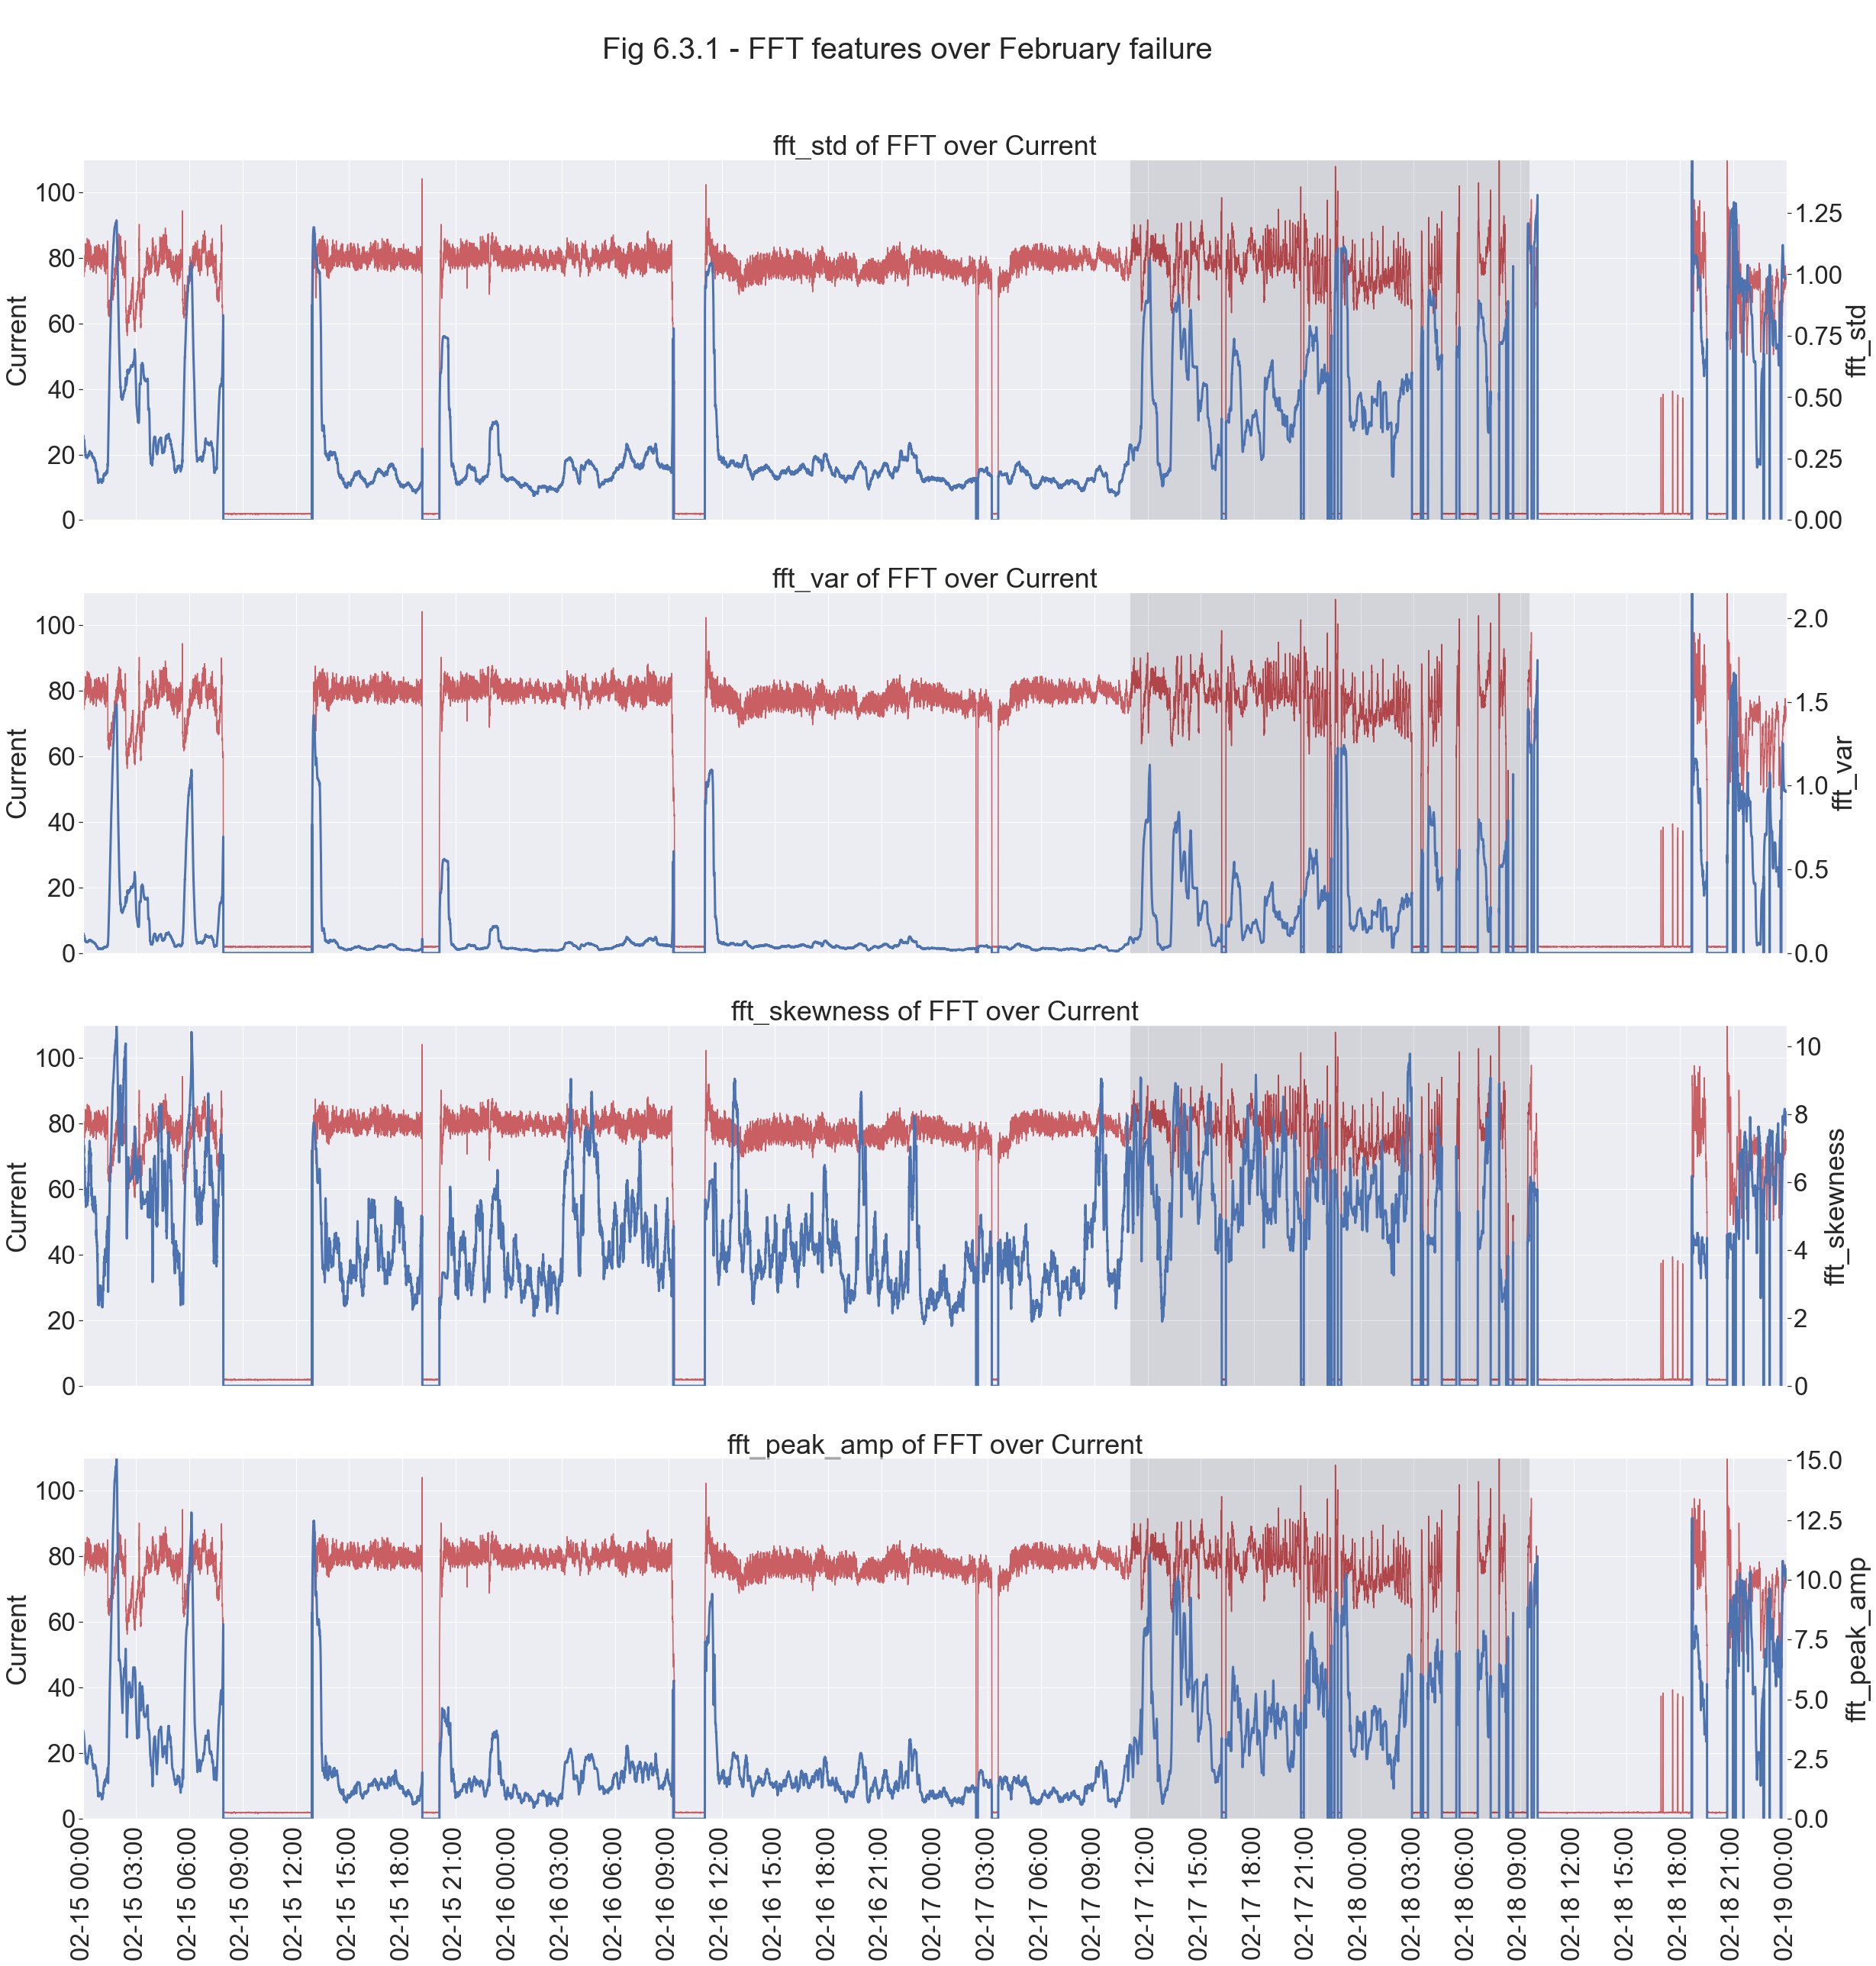

In [27]:
sns.set_theme(font_scale = 3) 

data_feb = data[(data['Date&Time'] >= '2022-02-15 00:00:00') & (data['Date&Time'] <= '2022-02-19 00:00:00')]

signals = ['fft_std', 'fft_var', 'fft_skewness', 'fft_peak_amp']

fig, ax = plt.subplots(len(signals), 1, figsize=(40,40), sharex = True)
loc, label = axis_label(data_feb)
plt.suptitle('\nFig 6.3.1 - FFT features over February failure',fontsize=40, y = 0.95);

for i, signal in enumerate(signals):
    
    axi = ax[i].twinx()
    p = sns.lineplot(x = np.arange(0, len(data_feb)), y = data_feb['Current'], ax = ax[i], color = 'r')
    p = sns.lineplot(x = np.arange(0, len(data_feb)), y = data_feb[signal], ax = axi, lw = 3, color = 'b')
    
    axi.set_ylim(0, data_feb[signal].max())
    
    ax[i].set_xlim([0, len(data_feb)])
    ax[i].set_title(f'{signal} of FFT over Current')
    ax[i].set(ylabel='Current')
    ax[i].set_ylim([0,110])
    ax[i].set_xticks(loc, label, rotation = 90)
    
    p.pcolorfast(p.get_xlim(), p.get_ylim(),
          data_feb['fail'].values[np.newaxis],
          cmap='binary', alpha=0.1)
    
    plt.grid()

###### March failure:

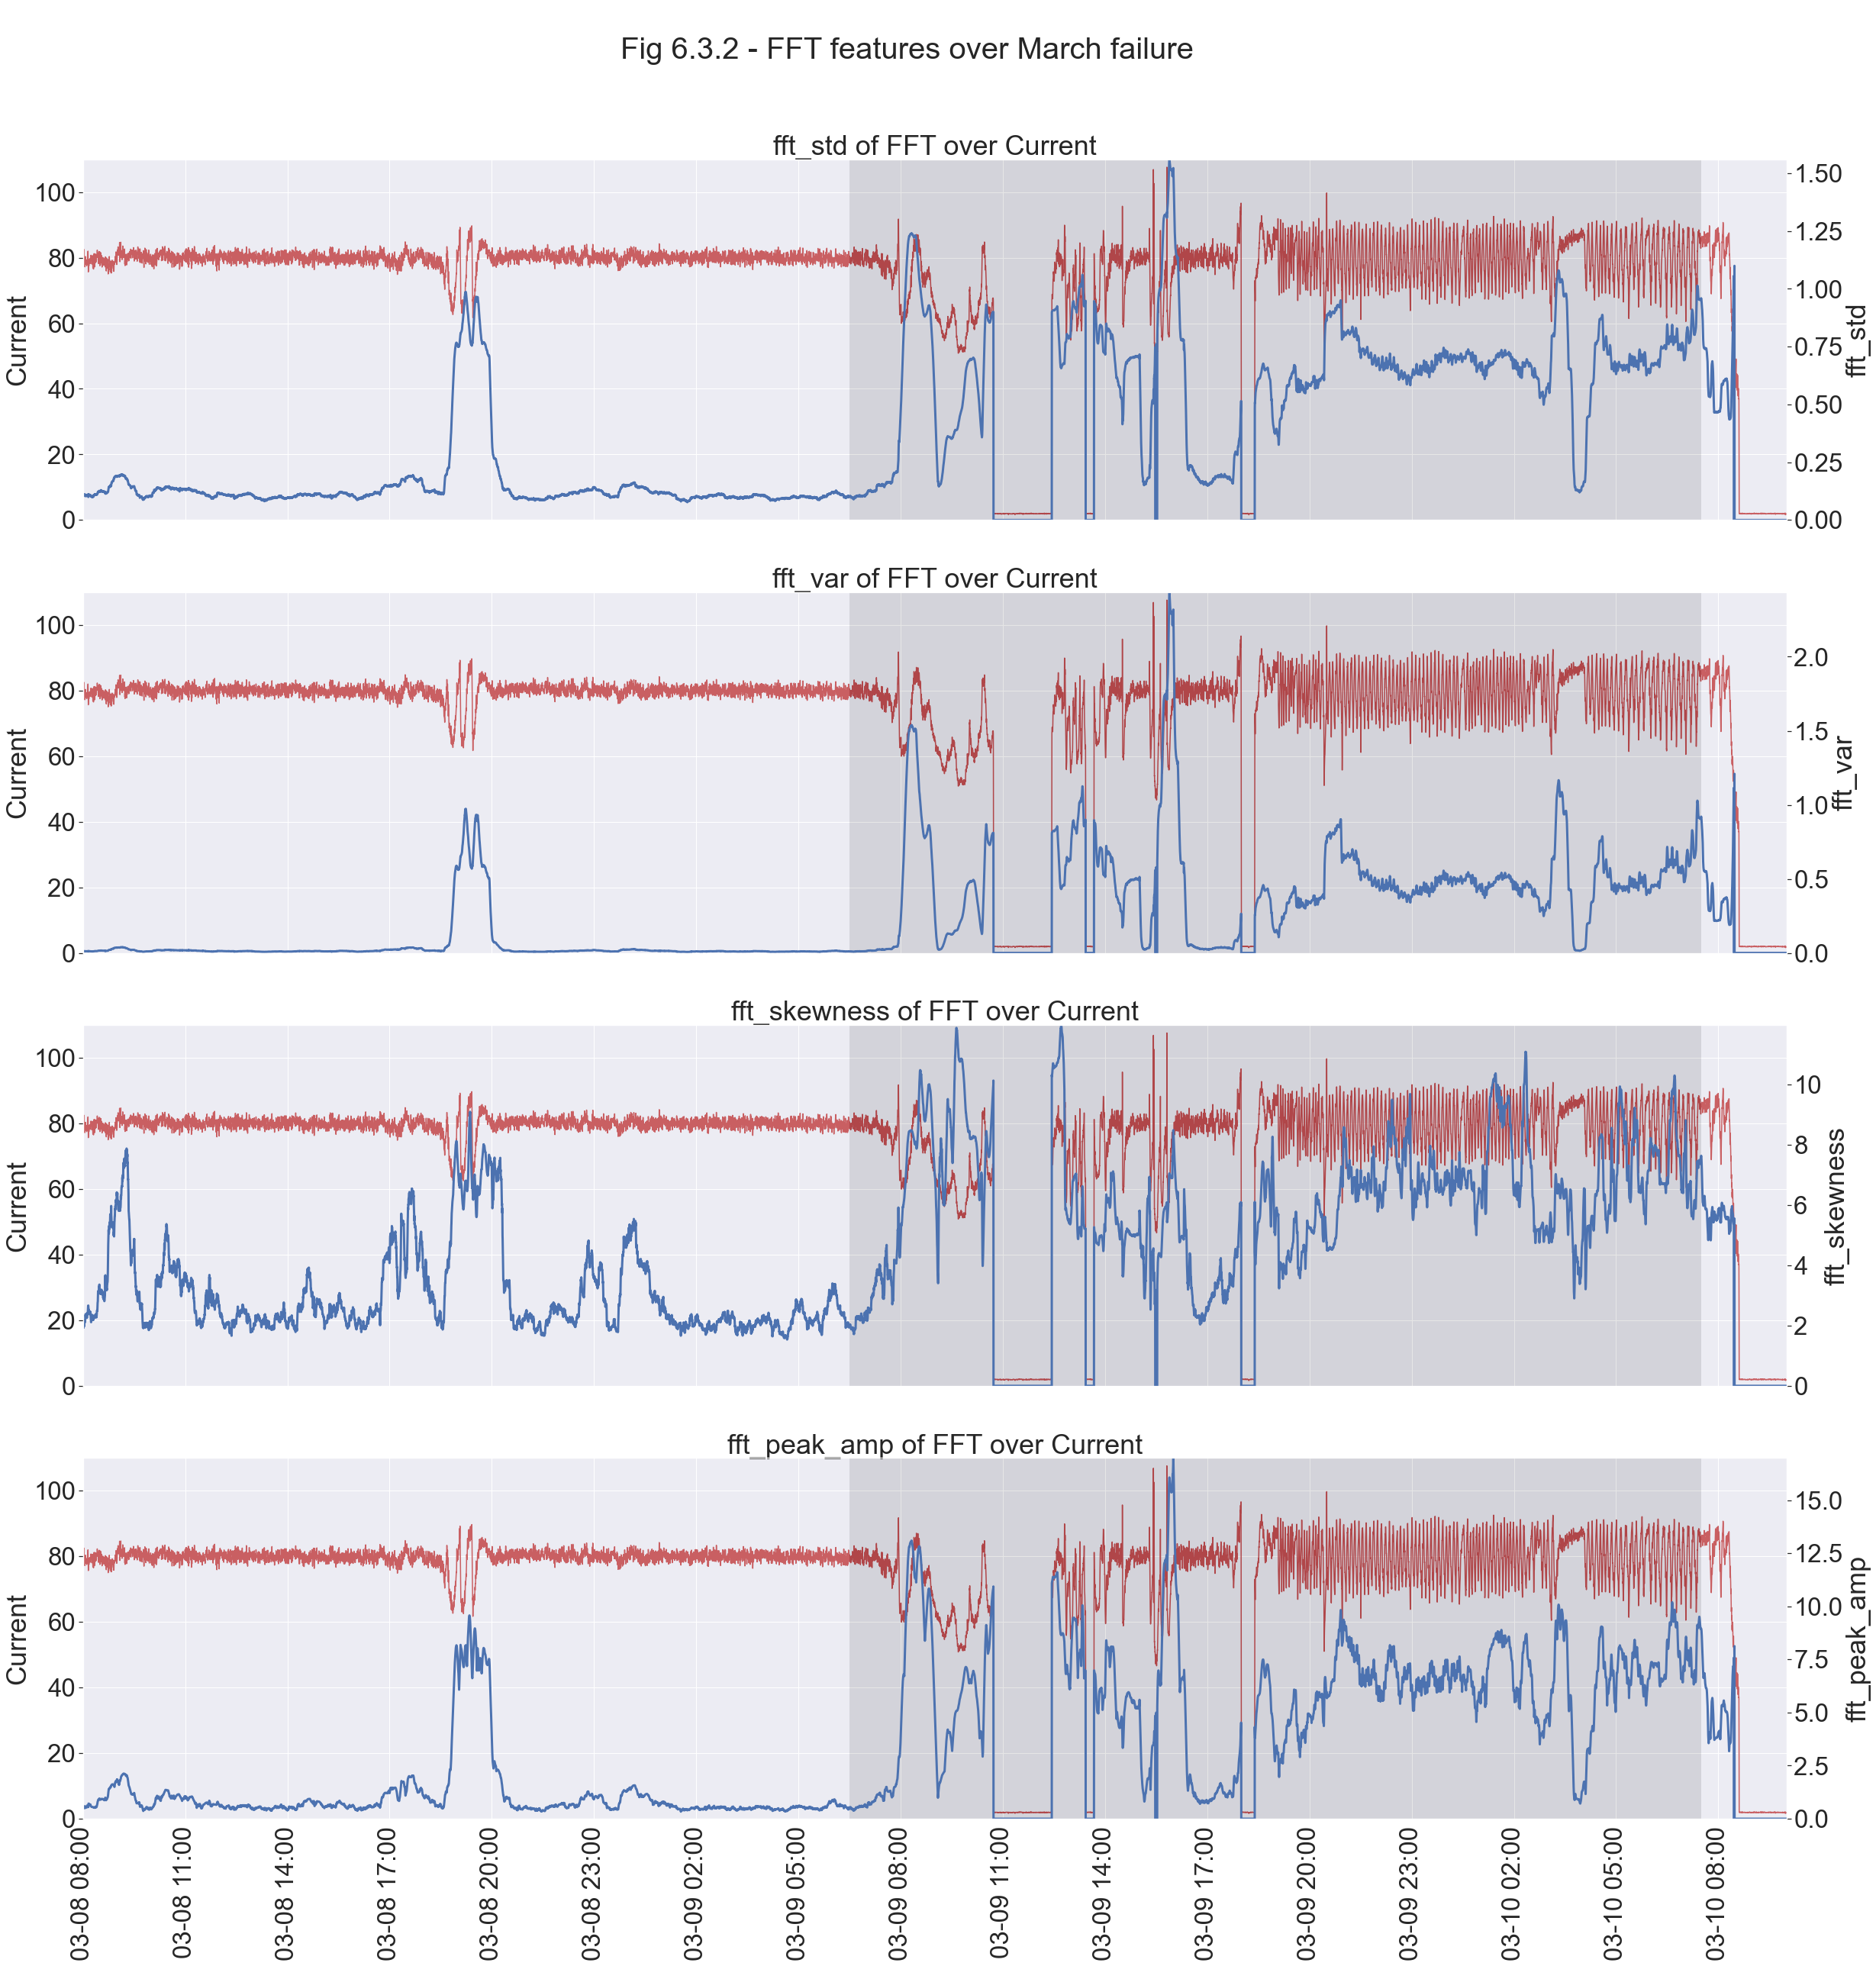

In [29]:
data_mar = data[(data['Date&Time'] >= '2022-03-08 08:00:00') & (data['Date&Time'] <= '2022-03-10 10:00:00')]

signals = ['fft_std', 'fft_var', 'fft_skewness', 'fft_peak_amp']

fig, ax = plt.subplots(len(signals), 1, figsize=(40,40), sharex = True)
loc, label = axis_label(data_mar)
plt.suptitle('\nFig 6.3.2 - FFT features over March failure',fontsize=40, y = 0.95);

for i, signal in enumerate(signals):
    
    axi = ax[i].twinx()
    p = sns.lineplot(x = np.arange(0, len(data_mar)), y = data_mar['Current'], ax = ax[i], color = 'r')
    p = sns.lineplot(x = np.arange(0, len(data_mar)), y = data_mar[signal], ax = axi, lw = 3, color = 'b')
    
    axi.set_ylim(0, data_mar[signal].max())
    
    ax[i].set_xlim([0, len(data_mar)])
    ax[i].set_title(f'{signal} of FFT over Current')
    ax[i].set(ylabel='Current')
    ax[i].set_ylim([0,110])
    ax[i].set_xticks(loc, label, rotation = 90)
    
    p.pcolorfast(p.get_xlim(), p.get_ylim(),
          data_mar['fail'].values[np.newaxis],
          cmap='binary', alpha=0.1)
    
    plt.grid()

in all cases, the features behave in a similar manner - low values when current is stable, and higher values when the current oscillates, which is exactly what we are looking for. 

Skewness, however, is less deterministic - high values seems to occur on both normal and abnormal signal.

Figure 6.3.3 presents histograms of the FFT features. For each histogram, I have calculated the skewness.
High skewness suggests that the feature efficiently separates abnormal from normal behavior.

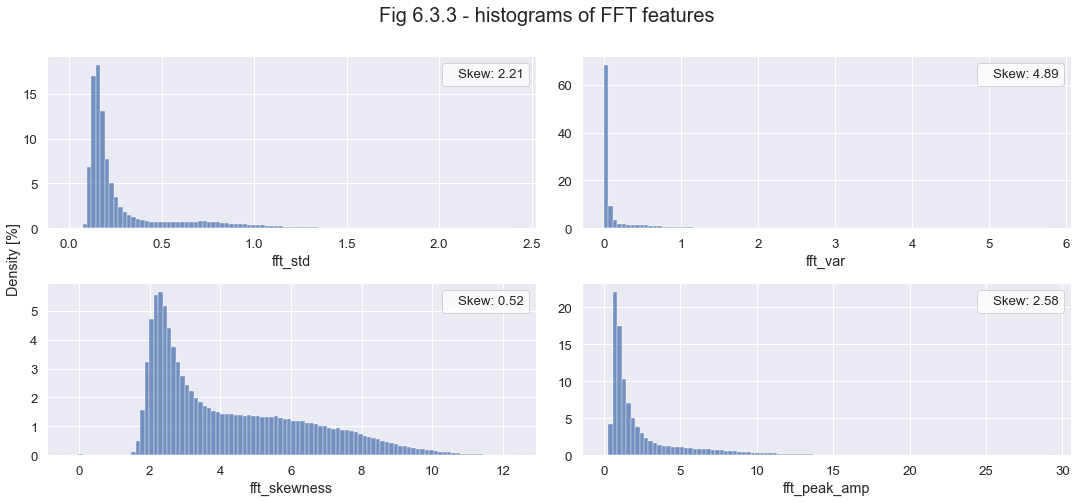

In [30]:
sns.set_theme(font_scale = 1.2) 

data_online = data[data['Current'] > 50]

signals = ['fft_std', 'fft_var', 'fft_skewness', 'fft_peak_amp']

fig, ax = plt.subplots(2,2, figsize = (15,7))
ax = ax.flatten()

fig.text(0, 0.5, 'Density [%]', va='center', rotation='vertical')
plt.suptitle('Fig 6.3.3 - histograms of FFT features',fontsize=20, y=1);

for i, signal in enumerate(signals):

    sns.histplot(data_online[signal], bins = 100, ax = ax[i], label = f'Skew: {round(skew(data[signal]), 2)}', stat = 'percent')
    ax[i].legend(handlelength=0, facecolor = 'white')
    ax[i].set(ylabel='')

plt.tight_layout()

Variance has the highest skewness, followed by standard deviation and peak power, last is skewness. 
This also fits the previous plots, where skewness seems the least informative.

### 6.4 Vibrations

Fig 6.4.1 presents Vibrations distribution. 

Vibrations describe the machines health quite well - low vibrations (up to 15 [mm/s]) indicate normal behavior, higher readings indicate abnormal behavior.

However, single peaks can occur due to various reasons and don't necessarily mean failure. On the other hand, a sequence of high reading over a short period of time is a strong failure indicator.  

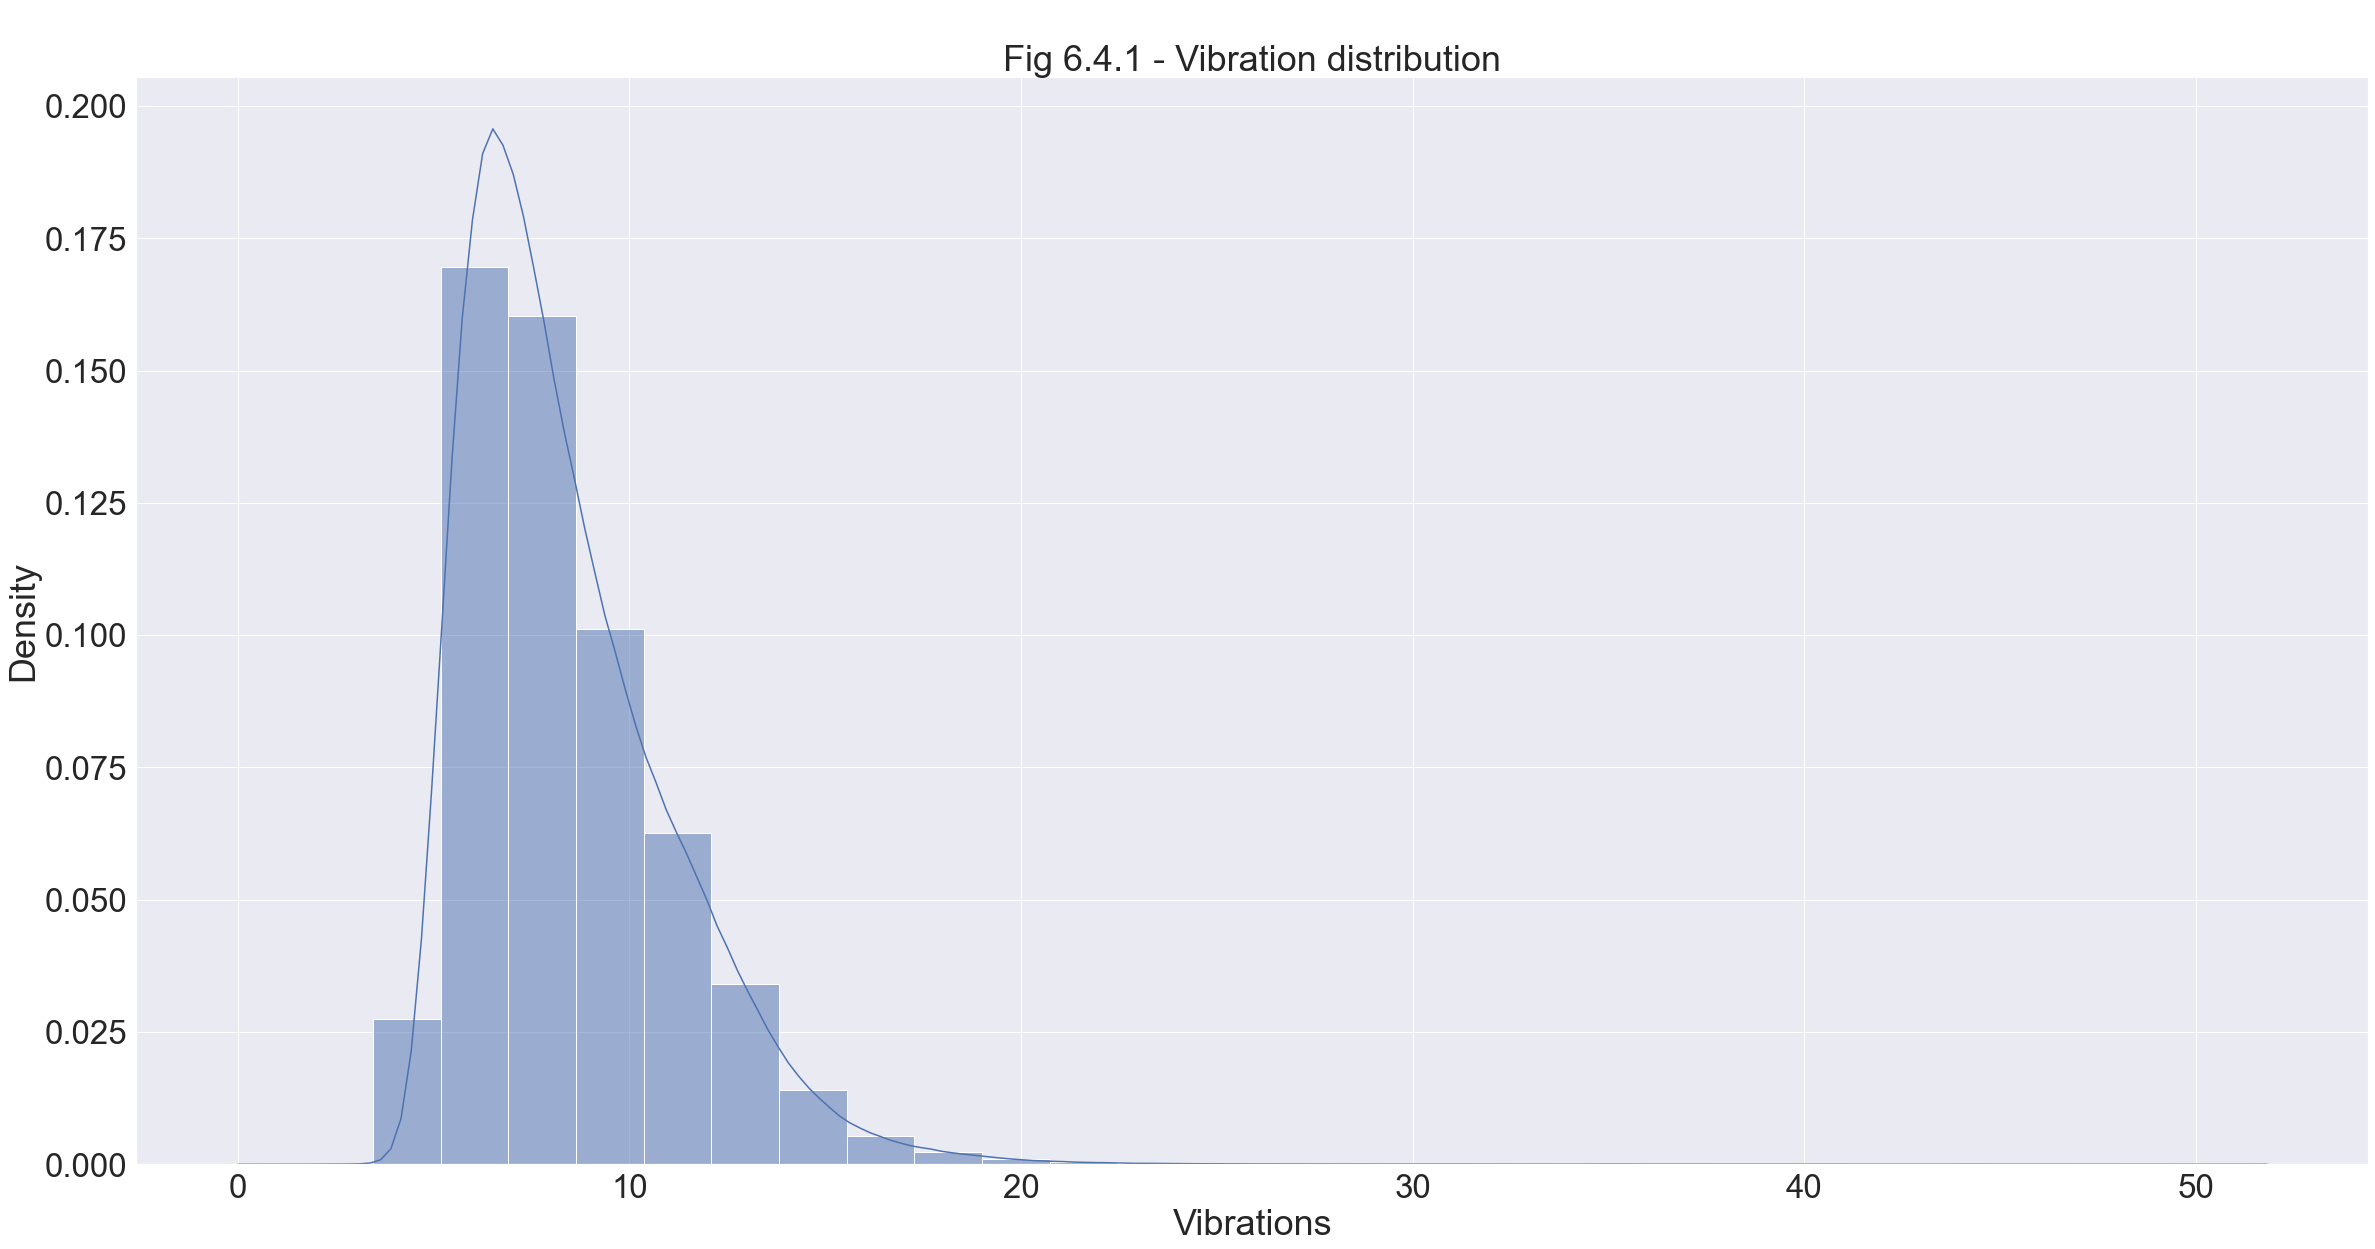

In [32]:
sns.set_theme(font_scale = 3)
p = sns.histplot(x = data['Vibrations'][data['Current'] > 50], bins = 30, stat="density", kde = True)
plt.title('\nFig 6.4.1 - Vibration distribution');

Fig 6.4.2 presents an example of a single peak (03-09 15:30) that should be filtered out, as opposed to high density of abnormal peaks, that should be emphasized.

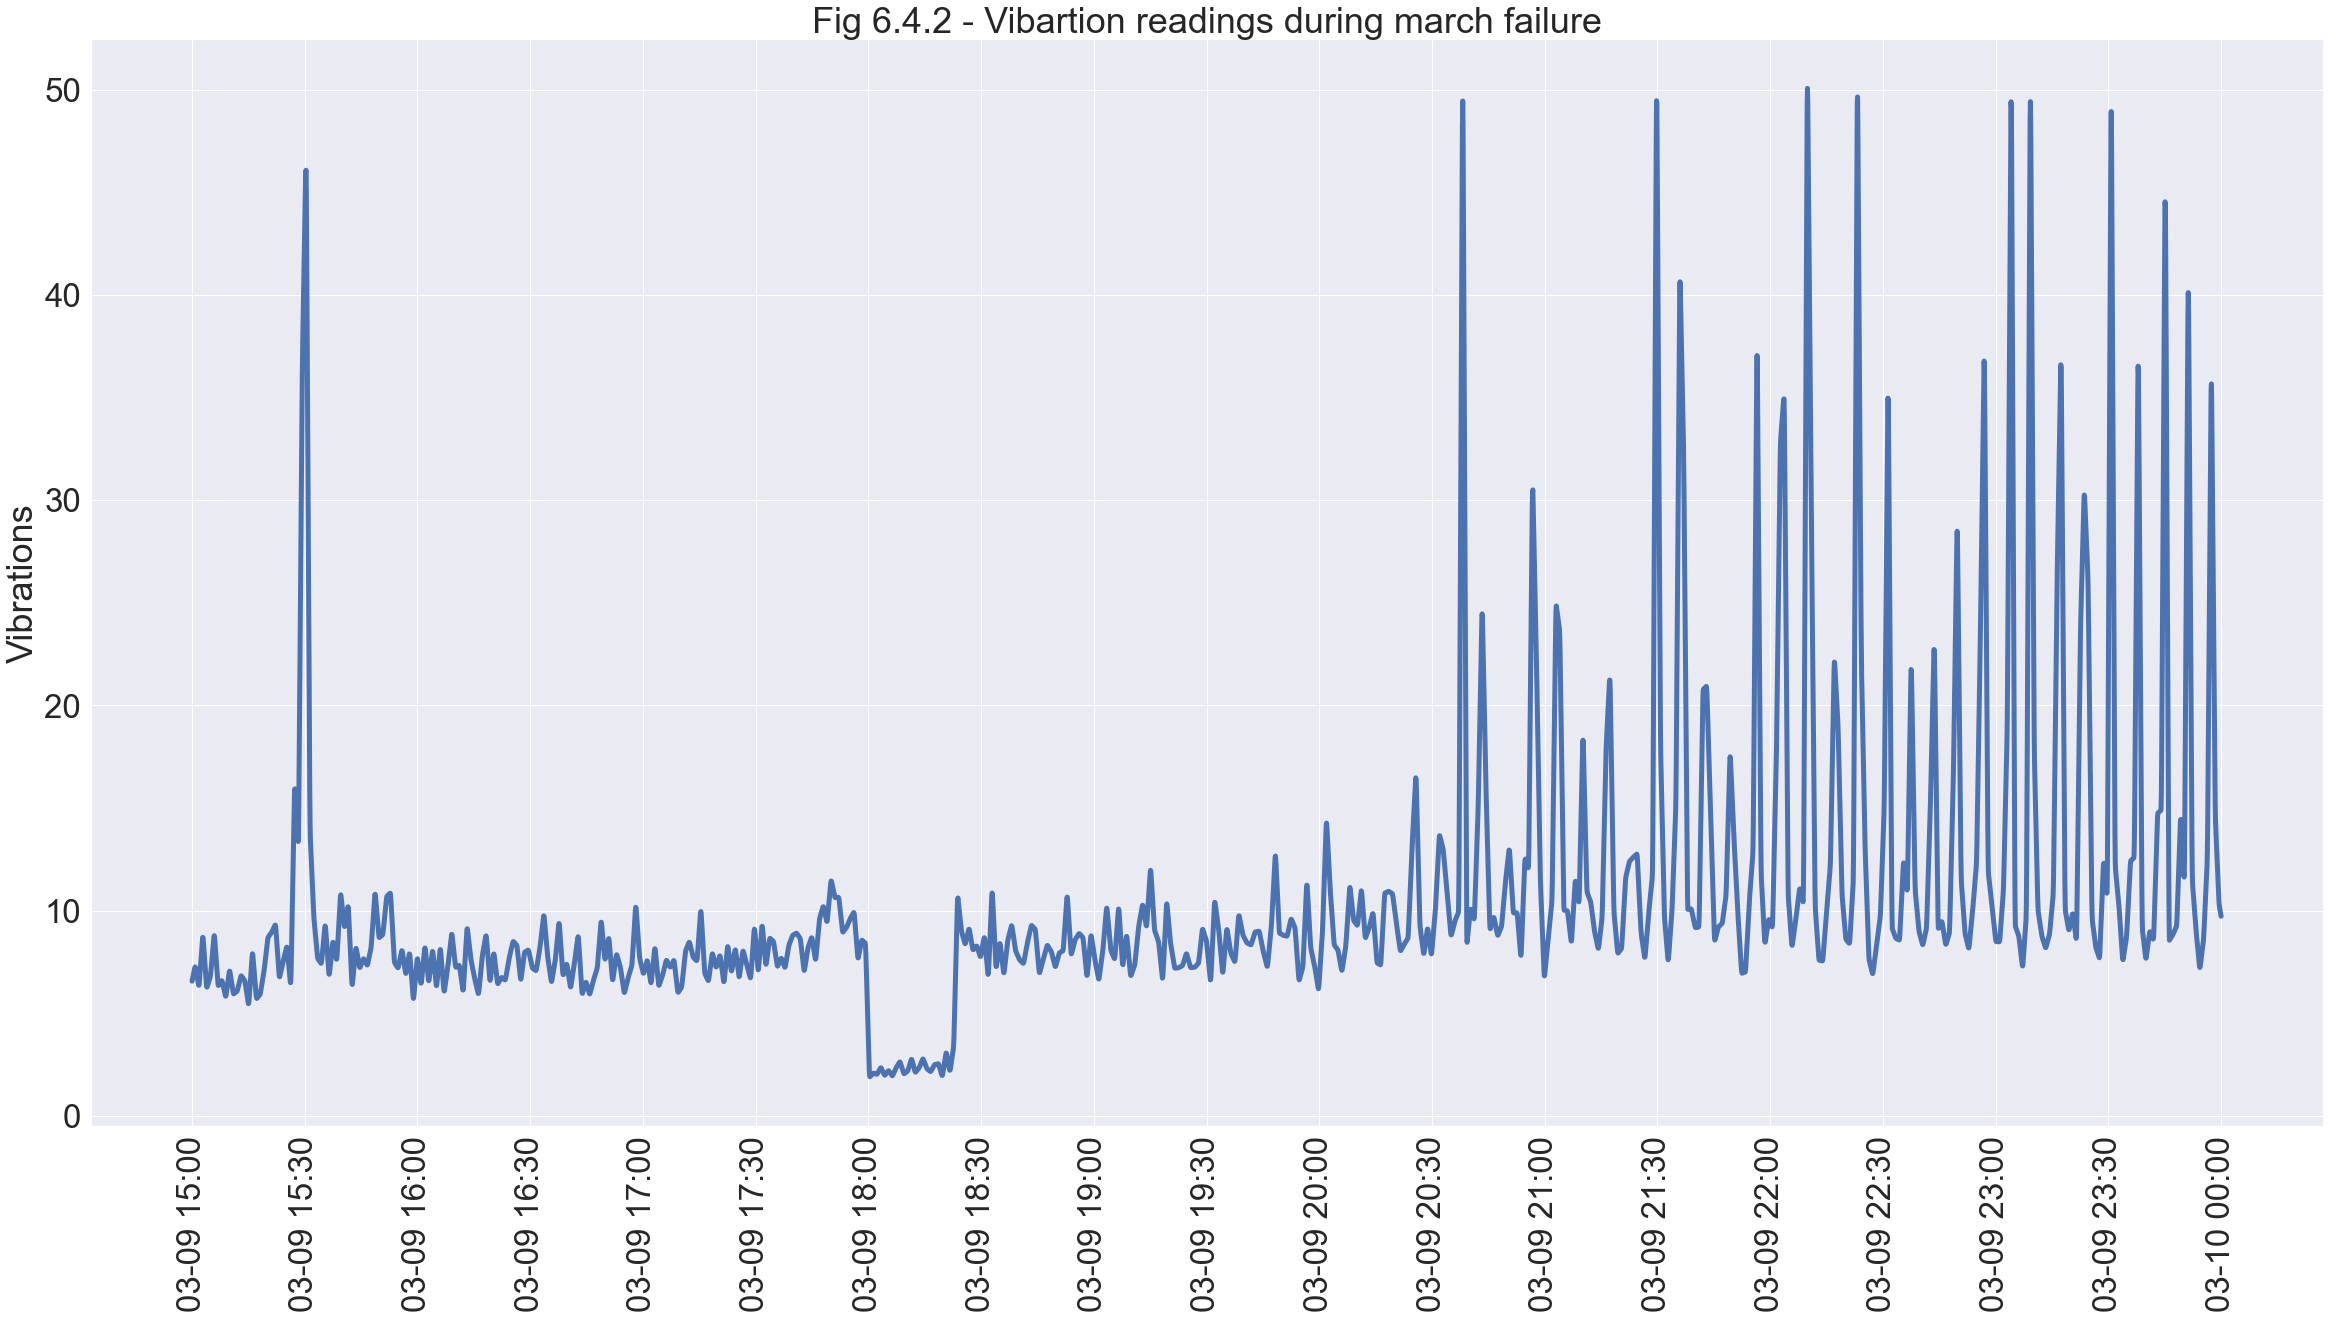

In [33]:
sns.set_theme(font_scale = 3)

df = data[(data['Date&Time'] >= '2022-03-09 15:00:00') & (data['Date&Time'] <= '2022-03-10 00:00:00')]
sns.lineplot(x = range(len(df)), y = df['Vibrations'], lw = 5)
plt.title('Fig 6.4.2 - Vibartion readings during march failure')
axis_label(df, 360);

I wanted to extract a new feature, which will enhance the effect of higher readings.

To do so, I have calculated local maximum, then linearly interpolated those points, and calculated the moving average (MA). The results are presented in fig 6.4.3 and 6.4.4.


In [41]:
data_online = data[data['Current'] > 50].copy().reset_index(drop = True)

# setting 30 min window
window = 360

#find indexs of local maximum
peaks = np.where(np.diff(np.sign(np.diff(data_online['Vibrations'].values)))<0)[0]+1

#Linear interpulating and moving average:
data_online['vib_peaks_MA'] = np.nan
data_online.loc[peaks, 'vib_peaks_MA'] = data_online['Vibrations'].values[peaks]
data_online['vib_peaks_MA'] = data_online['vib_peaks_MA'].interpolate()
data_online['vib_peaks_MA'] = data_online['vib_peaks_MA'].rolling(window).mean()

data = pd.merge(data, data_online[['Date&Time', 'vib_peaks_MA']], on = 'Date&Time', how = 'left')
data.fillna(0, inplace = True)

#remove first 360 rows
data = data.iloc[window-1:, :]

del data_online

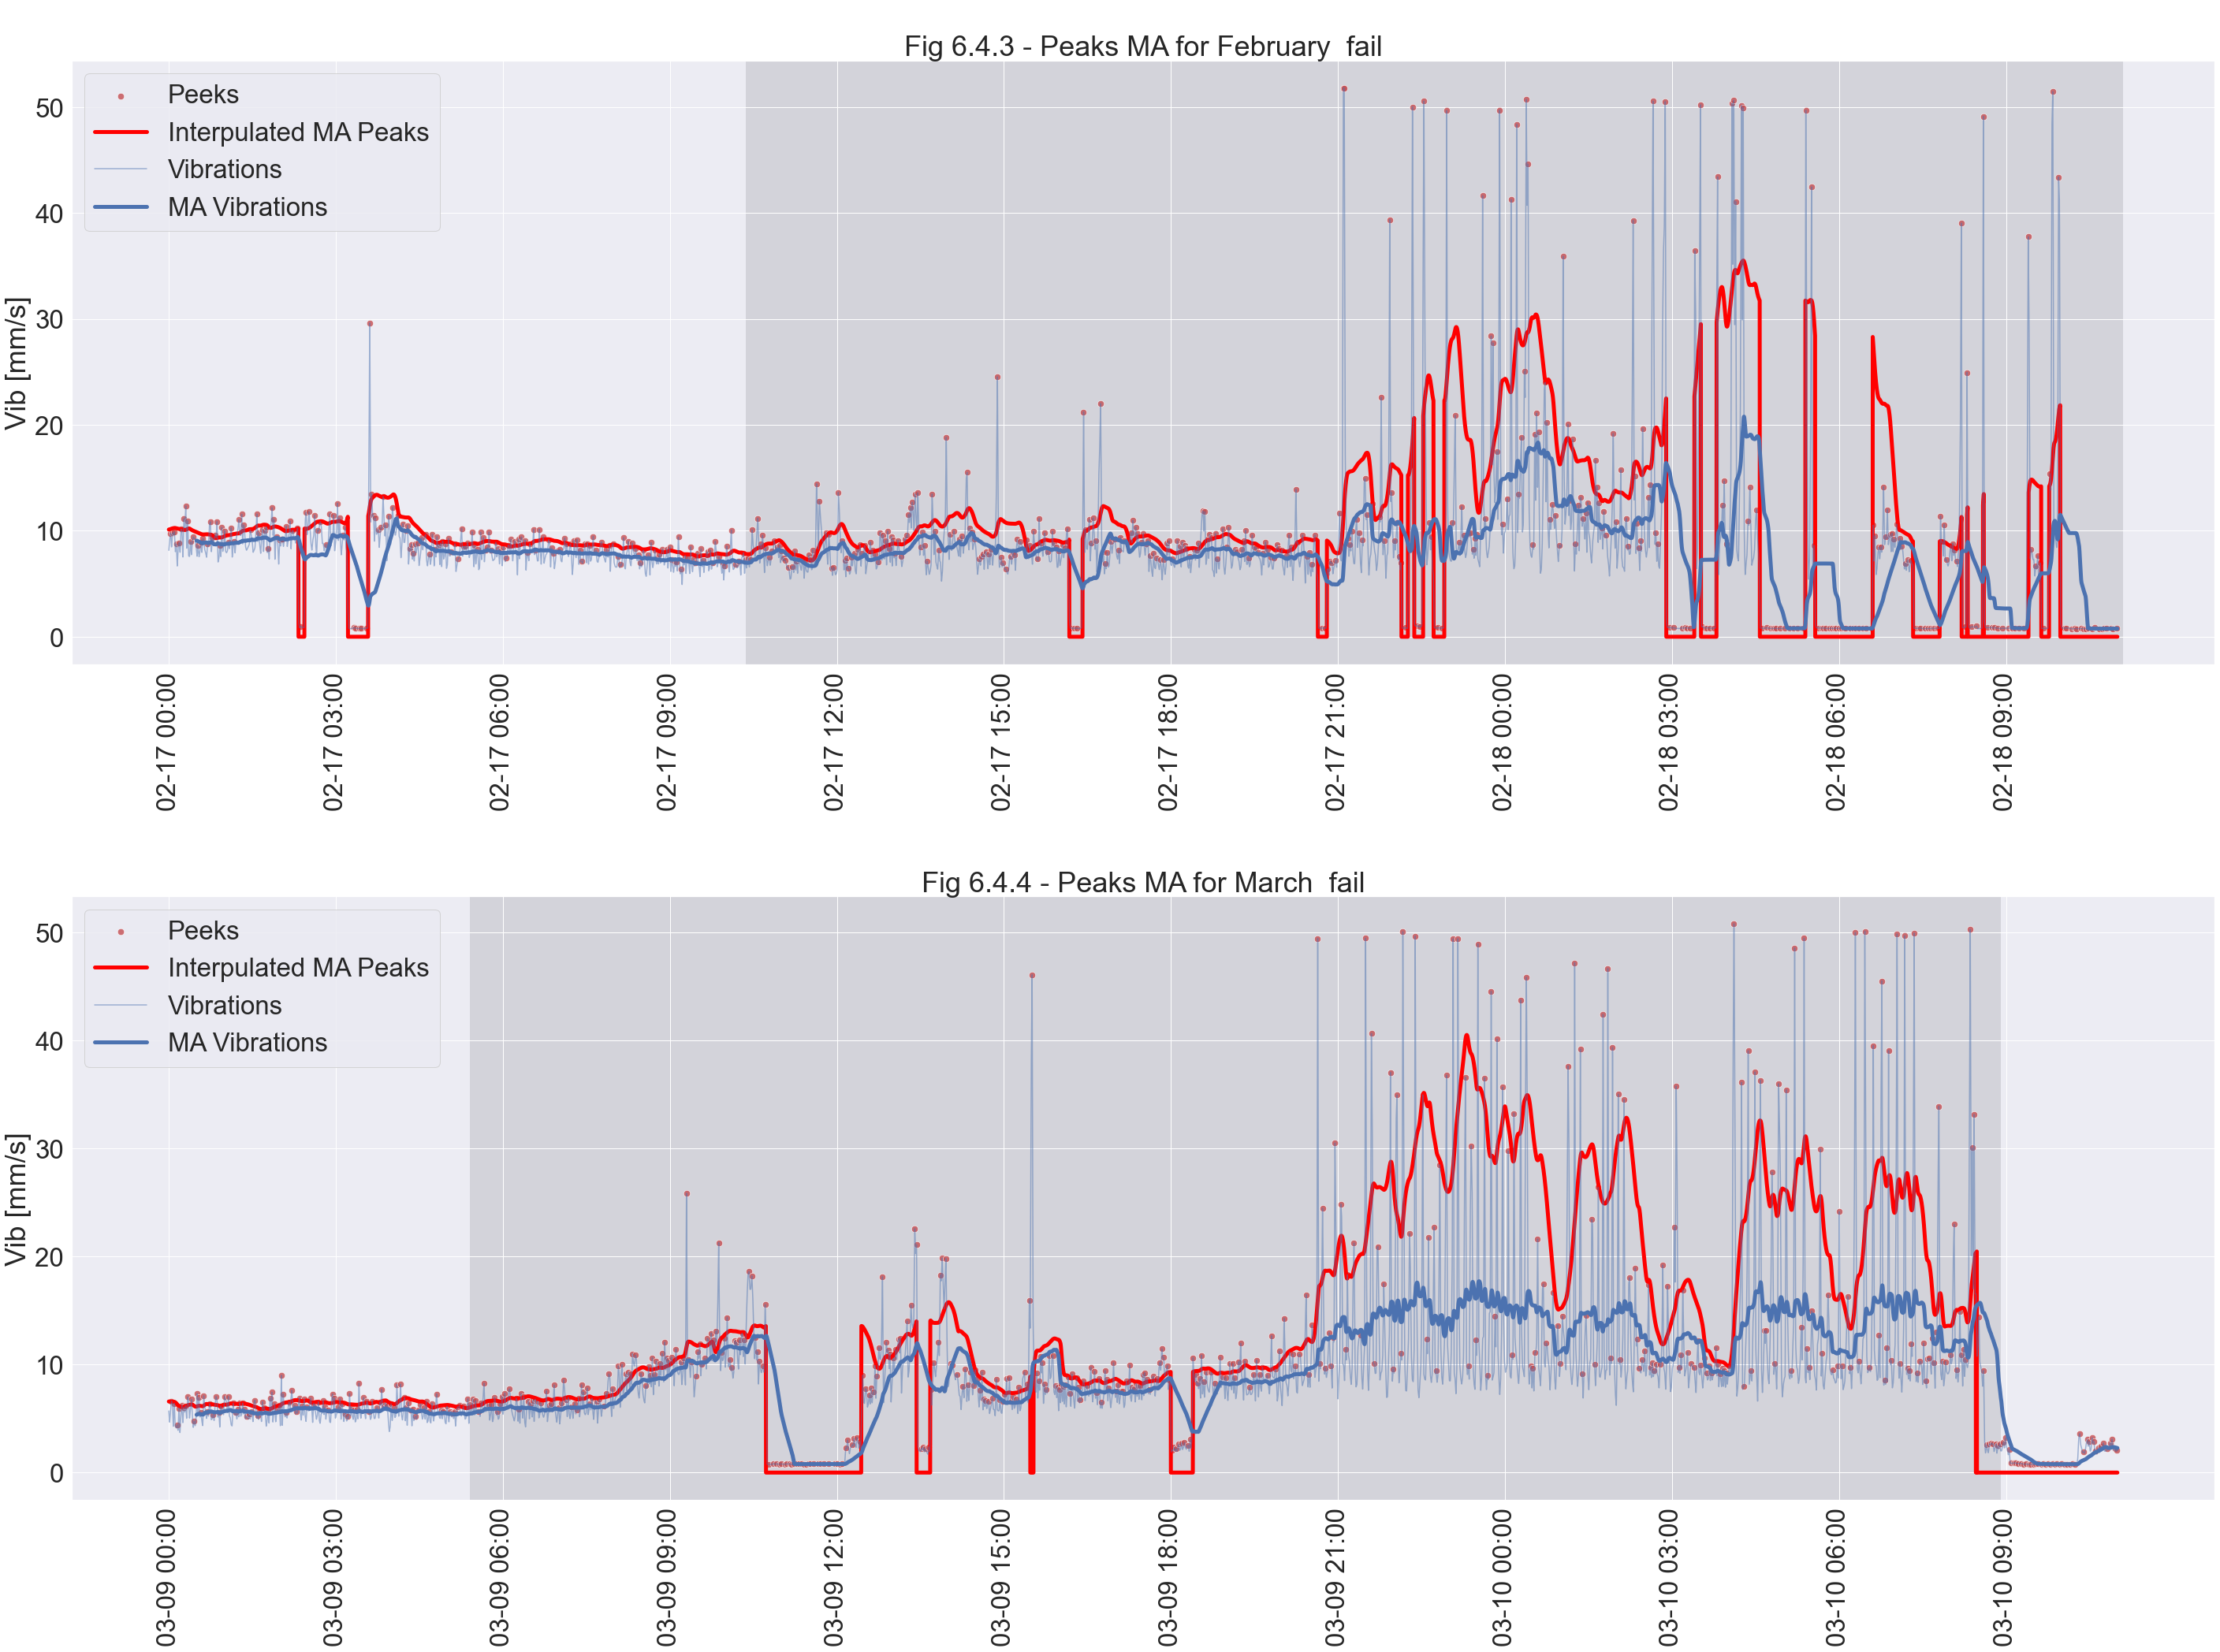

In [42]:
data_feb = data[(data['Date&Time'] >= '2022-02-17 00:00:00') & (data['Date&Time'] <= '2022-02-18 11:00:00')]
data_mar = data[(data['Date&Time'] >= '2022-03-09 00:00:00') & (data['Date&Time'] <= '2022-03-10 11:00:00')]

sns.set_theme(font_scale = 3) 

fig, ax  = plt.subplots(2,1, figsize = (40,30))

for i, df in enumerate([data_feb, data_mar]):
    x_axis_interval, x_axis_labels = axis_label(df, 2160)
    
    peaks = np.where(np.diff(np.sign(np.diff(df['Vibrations'].values)))<0)[0]+1

    sns.scatterplot(x = np.array(range(len(df)))[peaks], y = df['Vibrations'].values[peaks], color = 'r', s=70, label = 'Peeks', alpha = 0.8, ax = ax[i])
    sns.lineplot(x = range(len(df)), y = df['vib_peaks_MA'], lw = 5, label = 'Interpulated MA Peaks', color = 'red', ax = ax[i])
    sns.lineplot(x = range(len(df)), y = df['Vibrations'], label = 'Vibrations', color = 'b', alpha = 0.5, ax = ax[i])
    sns.lineplot(x = range(len(df)), y = df['Vibrations'].rolling(window).mean(), lw = 5, label = 'MA Vibrations', color = 'b', alpha = 1, ax = ax[i])
    ax[i].legend(loc = 'upper left');
    ax[i].set_xticks(x_axis_interval, x_axis_labels, rotation = 90);
    ax[i].set_ylabel('Vib [mm/s]')
    ax[i].set_title('\nFig 6.4.{} - Peaks MA for {}  fail'.format(i+3, ['February', 'March'][i]))
    
    ax[i].pcolorfast(ax[i].get_xlim(), ax[i].get_ylim(),
          df['fail'].values[np.newaxis],
          cmap='binary', alpha=0.1)
    
plt.tight_layout()

Fig 6.4.3 Shows the difference between vibrations moving average (Blue line), and peaks moving average (red line)

During low vibrations, Peaks Ma follows Vibrations MA, while single peaks have little effect.
When high peaks increase in density (during failure), MA peaks rise accordingly, far above vibration peaks, as was initially intended.

### 6.5 Features correlations and selection

Fig 6.5.1 presents a heat map of feature correlation scores; each sub plot implements a different method.

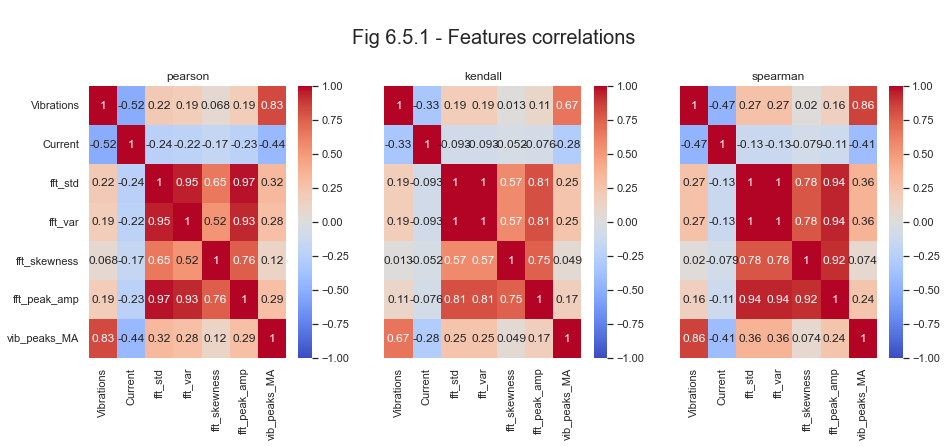

In [33]:
sns.set_theme(font_scale = 1) 

data_online = data[data['Current'] > 50].copy().reset_index(drop = True)

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey = True)

df = data_online[['Vibrations', 'Current', 'fft_std', 'fft_var', 'fft_skewness', 'fft_peak_amp', 'vib_peaks_MA']]

np.seterr(all = 'ignore')

plt.suptitle('\nFig 6.5.1 - Features correlations',fontsize=20, y = 1.1);

for i, method in enumerate(['pearson', 'kendall', 'spearman']):
    
    sns.heatmap(df.corr(method = method),\
                                 cmap = 'coolwarm', vmax=1, vmin=-1, ax = ax[i], annot = True)
    ax[i].title.set_text(method)
    
del df

As expected, fft_std and fft_var are perfectly correlated. fft_peak_amp also highly correlated to var and std, which is why I see no reason to use all three features in our model.

fft_Skewness has the lowest correlated than the other 3 (fft_std, fft_var, fft_peak_amp) and was very noisy (as can be seen in figures 6.3.1 and 6.3.2).

I decided to continue with only 4 features:
1. Current
2. Vibrations
3. fft_var
4. vib_peaks_MA.

In [43]:
#reducing memory required to store data
data.drop(['fft_std', 'fft_skewness', 'fft_peak_amp', 'detrend_crnt'], axis = 1, inplace = True)
data = np.round(data, 2)

In [44]:
data.head()

Date&Time  Vibrations  Current  fail  fft_var  vib_peaks_MA
359 2021-04-01 01:29:45       10.78    74.41     0     0.04           0.0
360 2021-04-01 01:29:50       10.72    74.28     0     0.04           0.0
361 2021-04-01 01:29:55       10.65    74.07     0     0.04           0.0
362 2021-04-01 01:30:00       10.59    73.76     0     0.04           0.0
363 2021-04-01 01:30:05       10.53    73.36     0     0.04           0.0

# 7. Extended Isolation forest training and predictions

### 7.1 Extended vs normal isolation forest

Isolation forest (IF) generates a bias in the scores where data is highly concentrated, further information can be found [here](https://ieeexplore.ieee.org/document/8888179)

To show the bias issue of our trained model, I plotted two anomaly score maps of normal and extended isolation forest (EIF), as seen in Fig 7.1, similar to the process of the first example in the link above.

For simplicity, I trained the model with vibrations and current features only.

In [45]:
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.333-b02, mixed mode)
  Starting server from C:\Users\Evia\anaconda3\envs\spyder-env\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Evia\AppData\Local\Temp\tmppfz24009
  JVM stdout: C:\Users\Evia\AppData\Local\Temp\tmppfz24009\h2o_Evia_started_from_python.out
  JVM stderr: C:\Users\Evia\AppData\Local\Temp\tmppfz24009\h2o_Evia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Asia/Jerusalem
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.3
H2O_cluster_version_age:    8 days
H2O_cluster_name:           H2O_from_python_Evia_w335r4
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.643 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.5 final
--------------------------  -----------------------------

In [52]:
train = data[['Vibrations', 'Current']][data['Current'] > 50]
h2o_train = h2o.H2OFrame(train)

In [53]:
predictors = ['Vibrations', 'Current']

xx, yy = np.meshgrid(np.linspace(0, 55, 500), np.linspace(50, 110, 500))

h2o_test = h2o.H2OFrame(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['Vibrations', 'Current']))

#Train normal Isolation Forest (extension_level = 0)
nif = H2OExtendedIsolationForestEstimator(model_id = 'eif.hex',
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = 0)

nif.train(x = predictors, training_frame = h2o_train)

S0 = nif.predict(h2o_test)["anomaly_score"].as_data_frame().values
S0 = S0.reshape(xx.shape)

#Train Extended Isolation Forest
eif = H2OExtendedIsolationForestEstimator(model_id = 'eif.hex',
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = len(predictors) - 1)

eif.train(x = predictors, training_frame = h2o_train)
S1 = eif.predict(h2o_test)["anomaly_score"].as_data_frame().values
S1 = S1.reshape(xx.shape)

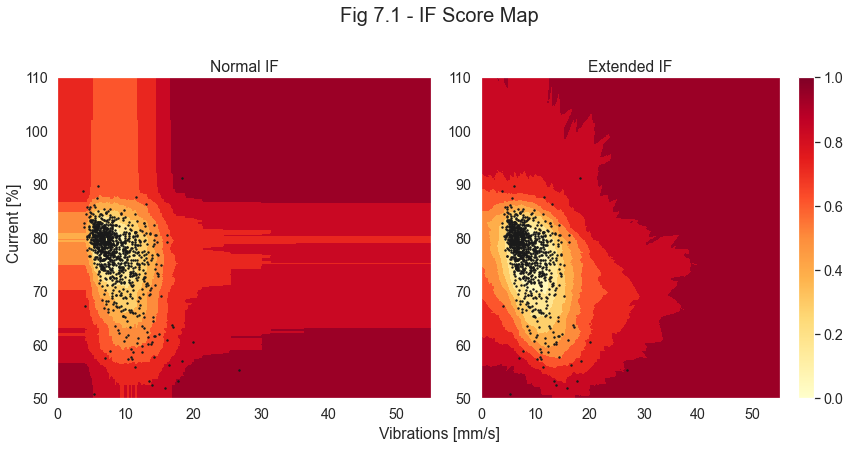

In [54]:
sns.set_theme(font_scale = 1.3) 

x = np.round(train[train['Current'] < 110]['Vibrations'].values, 1)
y = np.round(train[train['Current'] < 110]['Current'].values, 1)

xy = np.column_stack((x,y))
xy = xy[np.random.randint(0, len(xy), 1000)]

cmap=plt.cm.YlOrRd

fig = plt.figure(figsize=(12,6))

fig.text(0.5, 0, 'Vibrations [mm/s]', ha='center')
fig.text(0, 0.5, 'Current [%]', va='center', rotation='vertical')
plt.suptitle('Fig 7.1 - IF Score Map',fontsize=20, y=1);
plt.rcParams['axes.grid'] = False

ax1 = fig.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10);
CS = ax1.contourf(xx, yy, S0, levels, cmap=cmap)
plt.scatter(xy[:,0], xy[:,1], s = 2, color = 'k')
plt.title('Normal IF');

ax2 = fig.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10);
CS = ax2.contourf(xx, yy, S1, levels, cmap=cmap)
plt.scatter(xy[:,0], xy[:,1], s = 2, color = 'k')
plt.title('Extended IF');

#setting colorbar:
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(sm, ax=None, orientation='vertical'); 

plt.tight_layout()

In both cases, we can see low score region at 80% current and 10 [mm/s] vibrations. However, in the normal isolation forest, we can see regions of medium scores, in between 5 to 20[mm/s] Vibrations and between 60% to 85% Current.

Extended isolation forest has a reduced effect on the bias regions. Further improvement can be achieved by hyperparameters tunning.

### 7.2 Extended isolation forest tuning

Fig 7.2.1 illustrates the different effect sample size and tree number have on EIF scores.

100%|██████████| 6/6 [10:56<00:00, 109.50s/it]


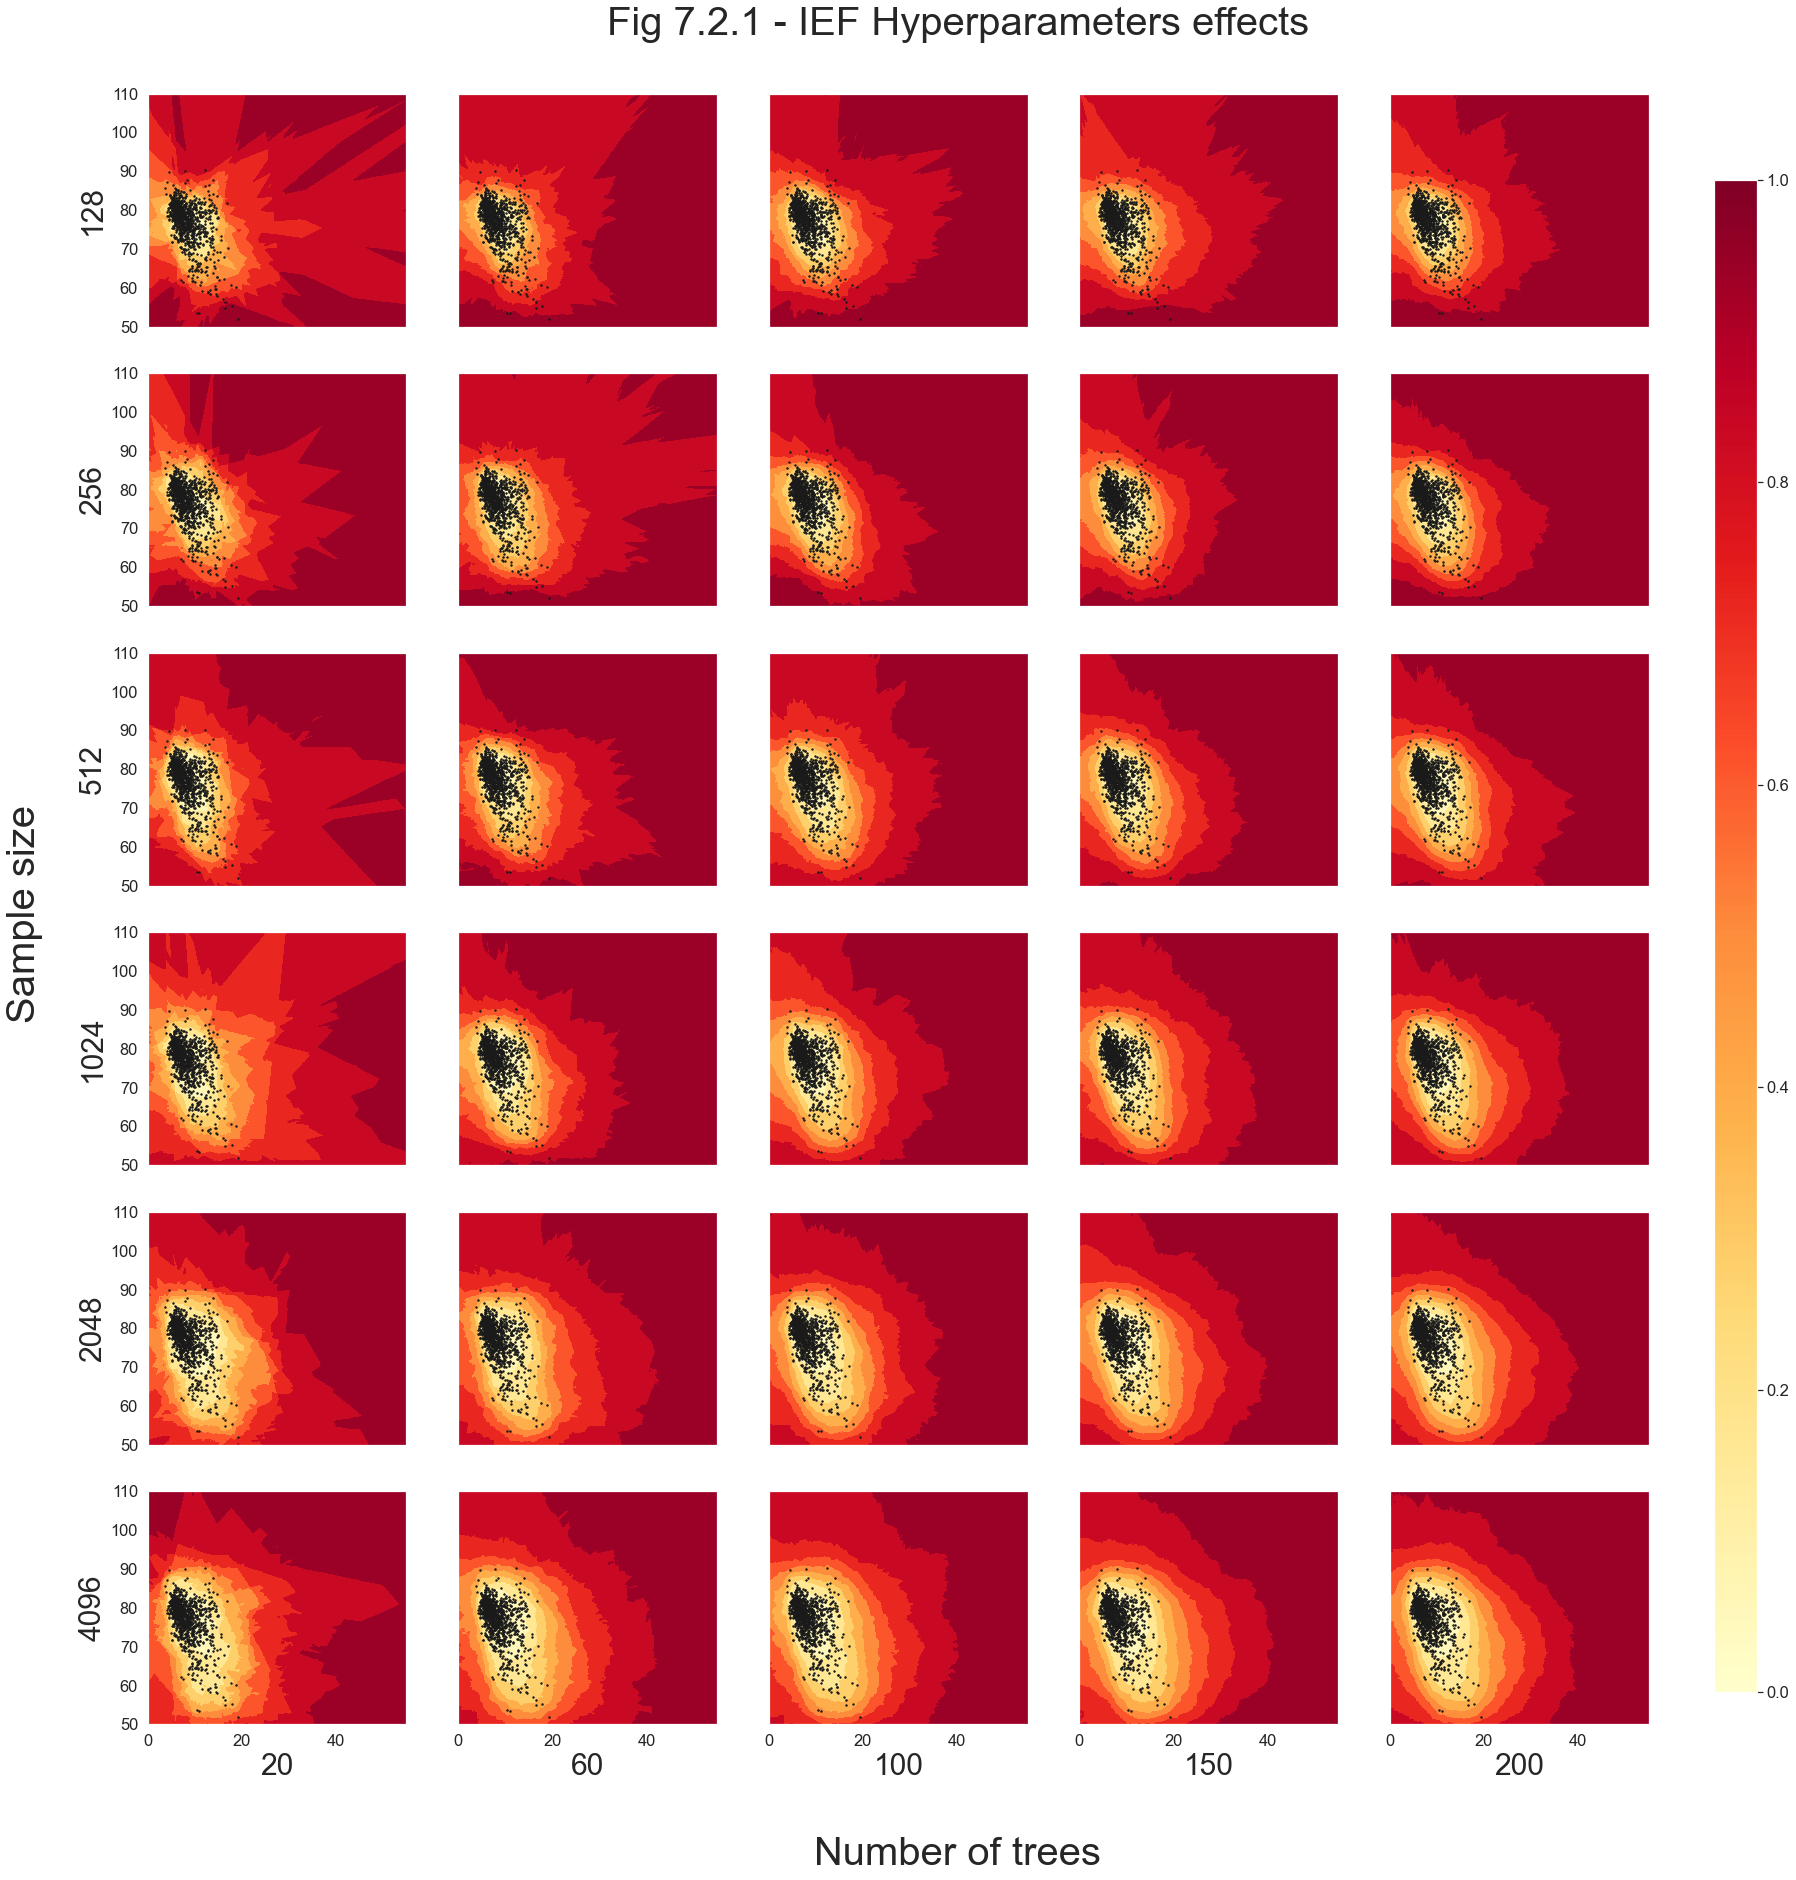

In [52]:
sns.set_theme(font_scale = 1.5) 

max_samples = [128, 256, 512, 1024, 2048, 4096]
n_estimators = [20, 60, 100, 150, 200]

fig, ax = plt.subplots(len(max_samples), len(n_estimators), sharex = True, sharey = True, figsize = (30, 30))

xx, yy = np.meshgrid(np.linspace(0, 55, 500), np.linspace(50, 110, 500))

x = np.round(train[train['Current'] < 110]['Vibrations'].values, 1)
y = np.round(train[train['Current'] < 110]['Current'].values, 1)

xy = np.column_stack((x,y))
xy = xy[np.random.randint(0, len(xy), 1000)]

cmap=plt.cm.YlOrRd

fig.text(0.5, 0.06, 'Number of trees', ha='center',fontsize=40)
fig.text(0.06, 0.5, 'Sample size', va='center', rotation='vertical',fontsize=40)
plt.suptitle('Fig 7.2.1 - IEF Hyperparameters effects',fontsize=40, y=0.92);
plt.rcParams['axes.grid'] = False

h2o_test = h2o.H2OFrame(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['Vibrations', 'Current']))

for sample in tqdm(range(len(max_samples))):
    
    for estimator in range(len(n_estimators)):

        #Train Extended Isolation Forest
        eif = H2OExtendedIsolationForestEstimator(model_id = 'eif.hex',
                                                  ntrees = n_estimators[estimator],
                                                  sample_size = max_samples[sample],
                                                  extension_level = len(predictors) - 1)

        eif.train(x = predictors, training_frame = h2o_train)
        S1 = eif.predict(h2o_test)["anomaly_score"].as_data_frame().values
        
        #S1 = pd.read_csv(r'A:\Isolation forest\data\2021-22 data\FFT data\Python\ief mx{} ne{}.csv'.format(max_samples[sample], n_estimators[estimator])).values
        S1 = S1.reshape(xx.shape)
        
        levels = np.linspace(np.min(S1),np.max(S1),10);
        ax[sample,estimator].contourf(xx, yy, S1, levels, cmap=cmap)
        ax[sample,estimator].scatter(xy[:,0], xy[:,1], s = 2, color = 'k')
        
        if estimator == 0:
            ax[sample,estimator].set_ylabel(max_samples[sample], fontsize=30)
        
        if sample == len(max_samples)-1:
            ax[sample,estimator].set_xlabel(n_estimators[estimator], fontsize=30)

fig.subplots_adjust(right=0.82)
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar_ax = fig.add_axes([0.85, 0.14, 0.02, 0.7])
fig.colorbar(sm, cax=cbar_ax, orientation='vertical');

### 7.2.1 - Number of trees:

Using 20 trees generates a "wild" bias at any given sample size. however, the more trees, the less difference can be observed. This kind of behavior is expected, because at some point, the difference in performance is neglectable.

### 7.2.2 - Sample size:

Sample size has a significant effect on model scores.

This matter was addressed in the original [paper](https://arxiv.org/pdf/1811.02141.pdf), which states:

    The isolation characteristic of iTrees enables them to build partial models and exploit sub-sampling to an extent that 
    is not feasible in existing methods. Since a large part of an iTree that isolates normal points is not needed for
    anomaly detection; it does not need to be constructed. A small sample size produces better iTrees because the swamping 
    and masking effects are reduced.

A small sub-sample will include mostly normal points, and very few anomalies. These anomalies can be isolated with less partitions, thus increasing the anomaly score and reducing swapping effect.
As each tree uses different sub-samples, each individual tree identifies different sets of anomalies.

On the other hand, as the sub-sample size increases, more partitions are required to isolate the anomalous instances, thus, reducing the score and increasing masking effect.

This is why the larger sample sizes results in a wider score distribution, for example, sample size of 4096, compared to 128.

### 7.2.3 - Conclusion

I decided to use a sample size of 512 and 150 trees because the distribution of the scores seems both narrow and stable (no "wild bias"), while using small sample size.

### 7.3 Final model training, generating scores

In [55]:
train = data[['Date&Time', 'Vibrations', 'Current', 'fft_var', 'vib_peaks_MA']][data['Current'] > 50].copy().reset_index(drop = True)

h2o_train = h2o.H2OFrame(train)

predictors = ['Vibrations', 'Current', 'fft_var', 'vib_peaks_MA']

eif = H2OExtendedIsolationForestEstimator(model_id = 'eif.hex',
                                          ntrees = 150,
                                          sample_size = 512,
                                          extension_level = len(predictors) - 1)

eif.train(x = predictors, training_frame = h2o_train)

score = eif.predict(h2o_train)["anomaly_score"].as_data_frame()

In [56]:
train = pd.concat([train['Date&Time'], score], axis = 1)
data = pd.merge(data, train, on = 'Date&Time', how = 'left')
data.fillna(0, inplace = True)
del train

In [62]:
data.head()

Date&Time  Vibrations  Current  fail  fft_var  vib_peaks_MA  \
0 2021-04-01 01:29:45       10.78    74.41     0     0.04           0.0   
1 2021-04-01 01:29:50       10.72    74.28     0     0.04           0.0   
2 2021-04-01 01:29:55       10.65    74.07     0     0.04           0.0   
3 2021-04-01 01:30:00       10.59    73.76     0     0.04           0.0   
4 2021-04-01 01:30:05       10.53    73.36     0     0.04           0.0   

   anomaly_score  
0       0.552863  
1       0.555250  
2       0.555912  
3       0.552609  
4       0.560643

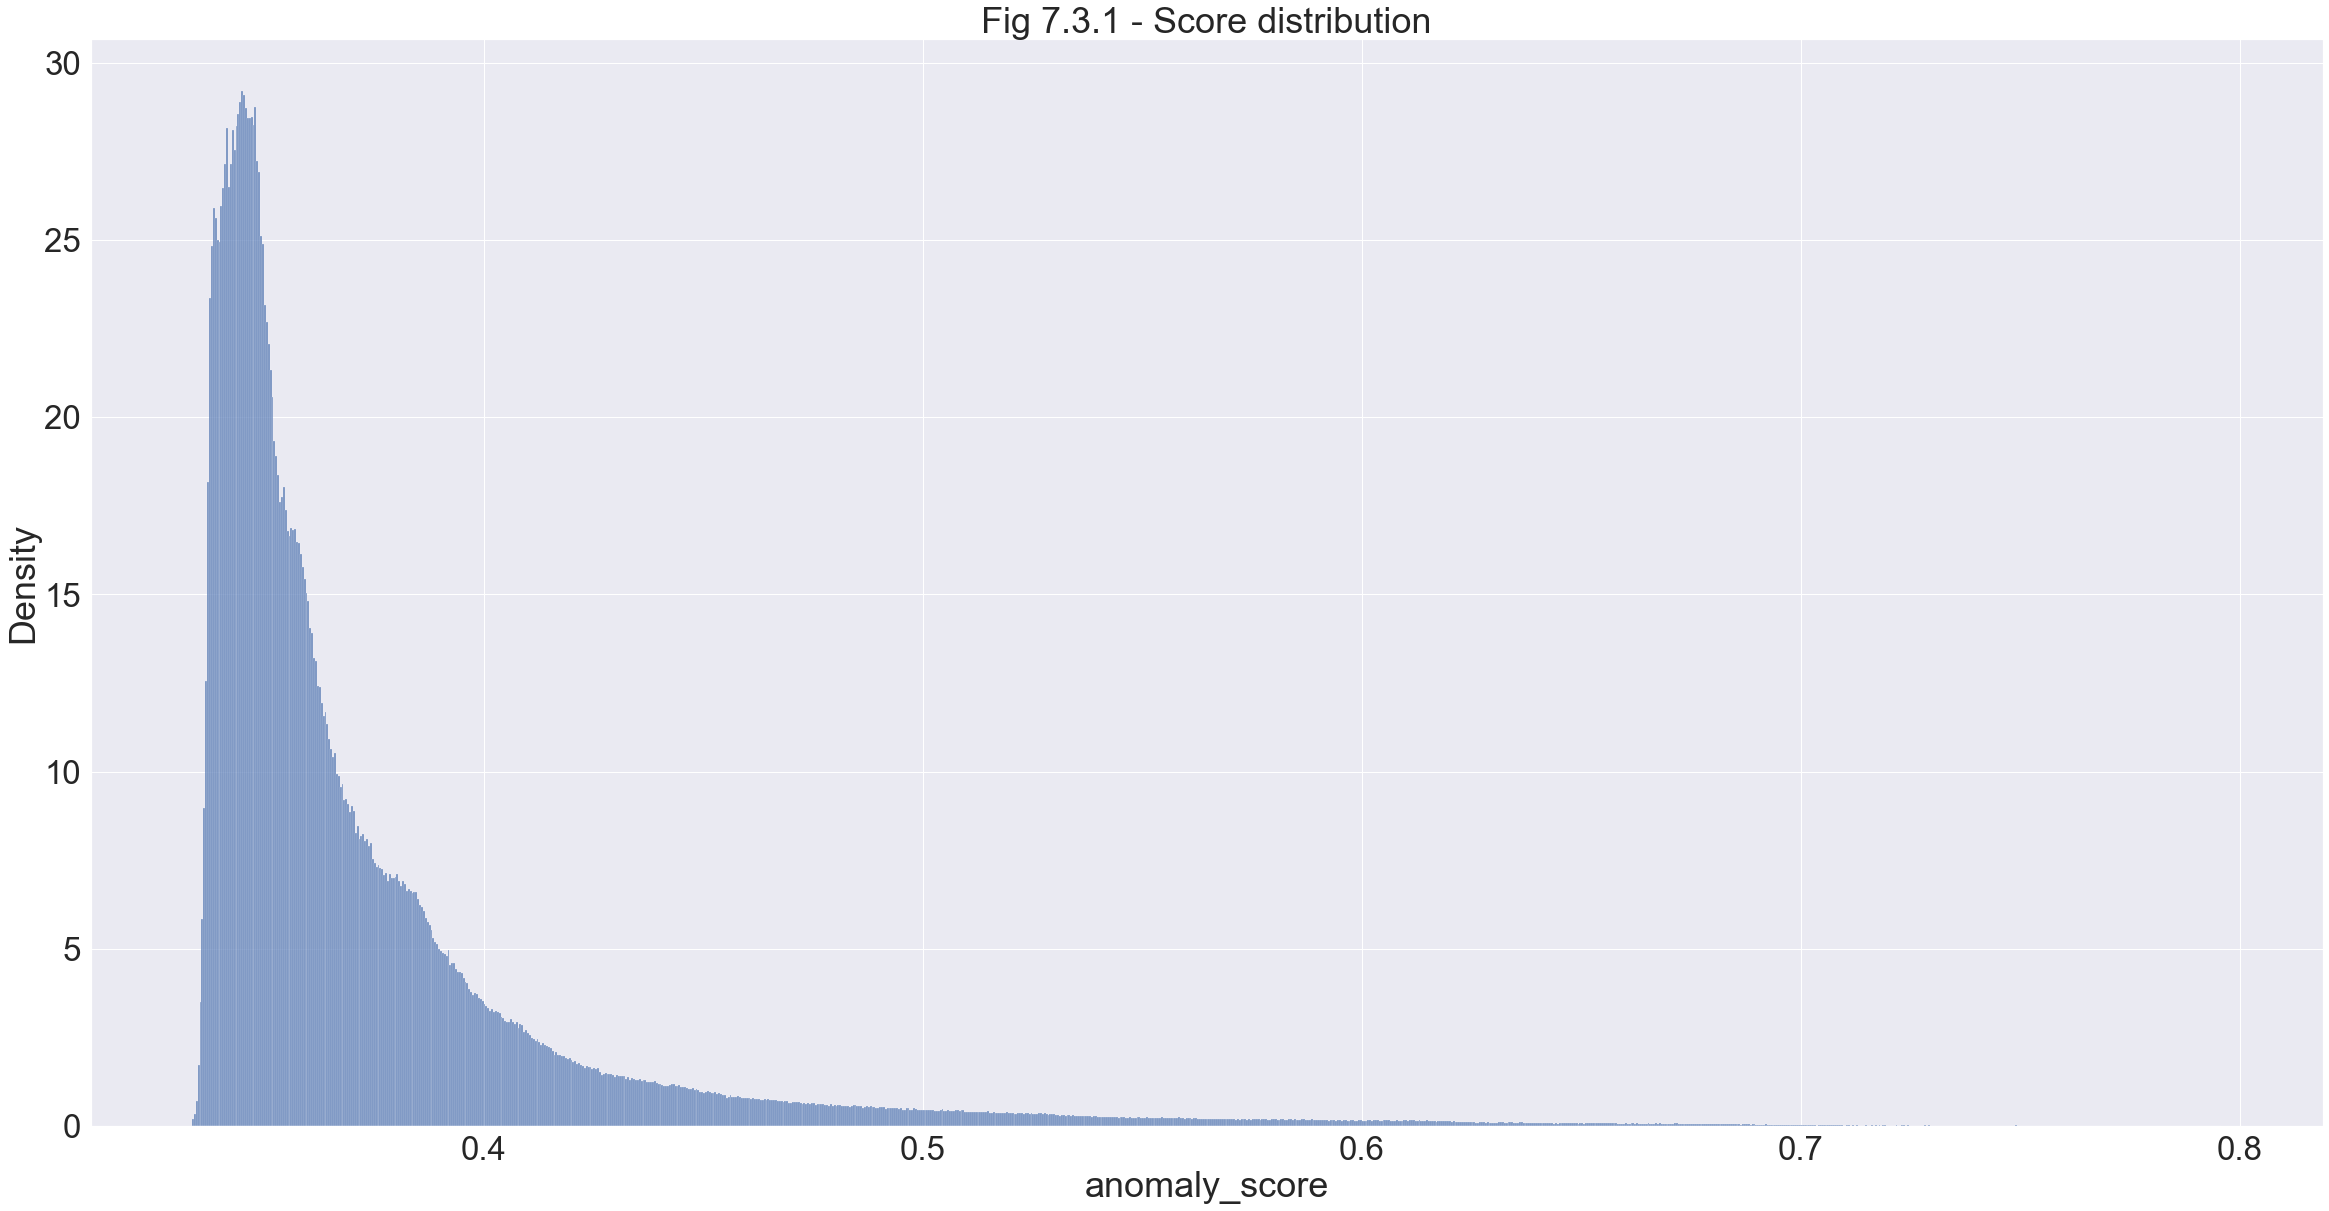

In [63]:
sns.set_theme(font_scale = 3) 

sns.histplot(data['anomaly_score'][data['Current'] > 50], stat = 'density');

plt.title('Fig 7.3.1 - Score distribution');

In [64]:
contamination = np.round(data['anomaly_score'][data['anomaly_score'] >= 0.5].count()/len(data)*100, 2)
print(f'Contamination: {contamination}%')

Contamination: 3.05%


### 8 - Transition from anomaly to alarms

Because anomalies alone are not enough to reliably detect a failure, further manipulations are required.

The original paper states that scores high above 0.5 are regarded as anomalies, while scores far below are normal.
We can see that the percentage of scores above 0.5 (termed ''contamination'') is approximately -3%.

Fig 8.1 and 8.2 presents the Vibration and Current readings during March and February fails. Orange background indicates anomaly scores above 0.5.

In [65]:
data['anomaly'] = np.where(data['anomaly_score'] <= 0.5, 0, 1)

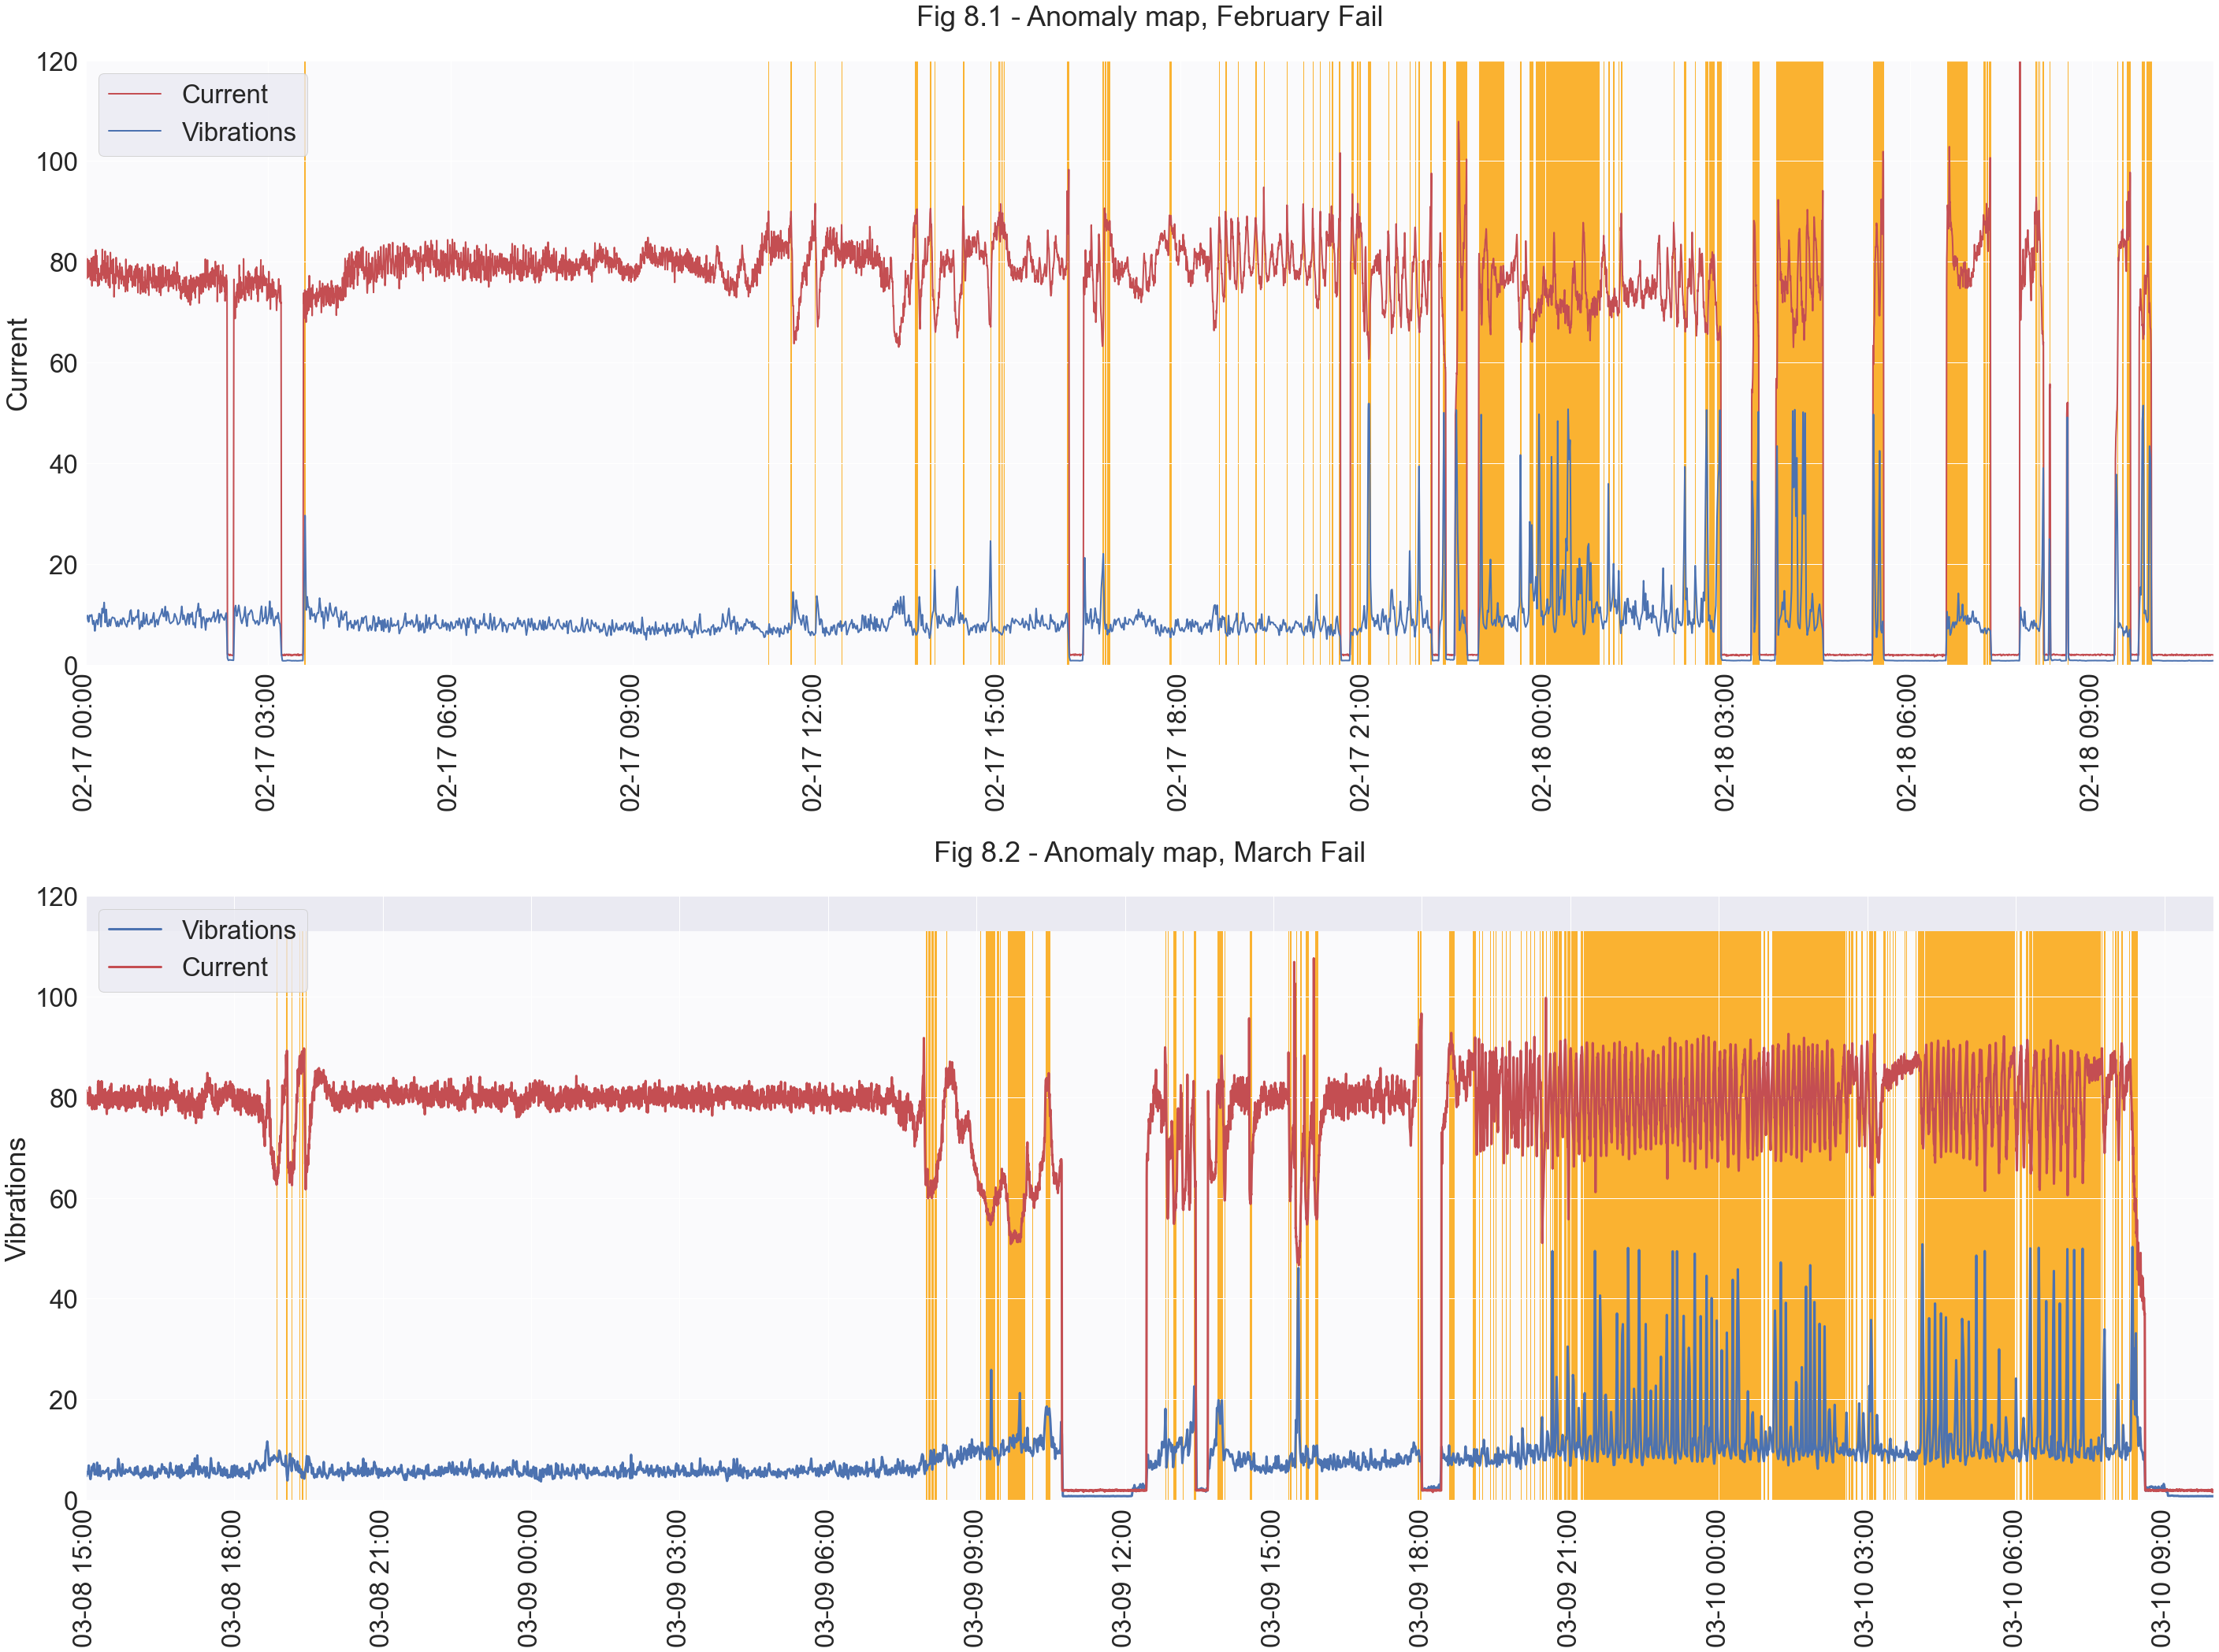

In [68]:
sns.set_theme(font_scale = 3) 

fig = plt.figure(figsize=(40,30))

cmap = matplotlib.colors.ListedColormap(['white', 'orange'])

ax1 = fig.add_subplot(211)
data_feb = data[(data['Date&Time'] >= '2022-02-17 00:00:00') & (data['Date&Time'] <= '2022-02-18 11:00:00')]

p = sns.lineplot(x = range(len(data_feb)), y = data_feb['Current'], label = 'Current', ax = ax1, color = 'r', lw = 2)
p = sns.lineplot(x = range(len(data_feb)), y = data_feb['Vibrations'], label = 'Vibrations', ax = ax1, color = 'b', lw = 2)

ax1.set_xlim(0,len(data_feb))

ax1.pcolorfast(p.get_xlim(), p.get_ylim(),
data_feb['anomaly'].values[np.newaxis],
cmap=cmap, alpha=0.8)

axis_label(data_feb)
plt.ylim(0, 120)
ax1.legend(loc = 'upper left');
ax1.set_title('Fig 8.1 - Anomaly map, February Fail', y = 1.05);

ax2 = fig.add_subplot(212)
data_mar = data[(data['Date&Time'] >= '2022-03-08 15:00:00') & (data['Date&Time'] <= '2022-03-10 10:00:00')]

sns.lineplot(x = range(len(data_mar)), y = data_mar['Vibrations'], label = 'Vibrations', ax = ax2, color = 'b', lw = 3)
p = sns.lineplot(x = range(len(data_mar)), y = data_mar['Current'], label = 'Current', ax = ax2, color = 'r', lw = 3)

ax2.set_xlim(0,len(data_mar))

ax2.pcolorfast(p.get_xlim(), p.get_ylim(),
data_mar['anomaly'].values[np.newaxis],
cmap=cmap, alpha=0.8)

axis_label(data_mar)
plt.ylim(0, 120)
ax2.legend(loc = 'upper left');
ax2.set_title('Fig 8.2 - Anomaly map, March Fail', y = 1.05);

plt.tight_layout()

In [69]:
data['year'] = data['Date&Time'].dt.year
data['month'] = data['Date&Time'].dt.month
data['day'] = data['Date&Time'].dt.day

In [70]:
days_witn_anomaly = data[['anomaly', 'year', 'month', 'day']].groupby(['year', 'month', 'day']).max().sum()[0]
print(f'Numbers of days with at least 1 anomaly: {days_witn_anomaly}')

Numbers of days with at least 1 anomaly: 354



The 0.5 threshold detects both March and February failures, however, over the past year, 354 days gave at least one anomaly detection. This is a very bad result (Recall the second goal of the project).

Increasing the threshold to 0.75 resulted in 83 days with alarms, which is still high and had poor failure detection.

For this reason, detecting a failure by anomaly alone is insufficient. To improve the results, two factors should be considered:

1. Anomaly score value - 0.5 score is much weaker than 0.75 and should be treated as such.
2. Anomaly density - Higher anomaly density can indicate a failure, while low densities are acceptable. 

To do so, I have calculated a moving average of 30 min window (360 rows). This way higher scores will increase the MA, but single anomalies will be ignored if the density is low.

Fig 8.3 and 8.4 plots the resulting MA score. We can see a good match between current and vibrations behavior to the MA score.


In [71]:
window = 360
data_online = data[data['Current'] > 50].copy().reset_index(drop = True)
data_online['rolled_score'] = data_online['anomaly_score'].rolling(window).mean()

In [72]:
data = pd.merge(data, data_online[['Date&Time', 'rolled_score']], on = 'Date&Time', how = 'left')
data.fillna(0, inplace = True)

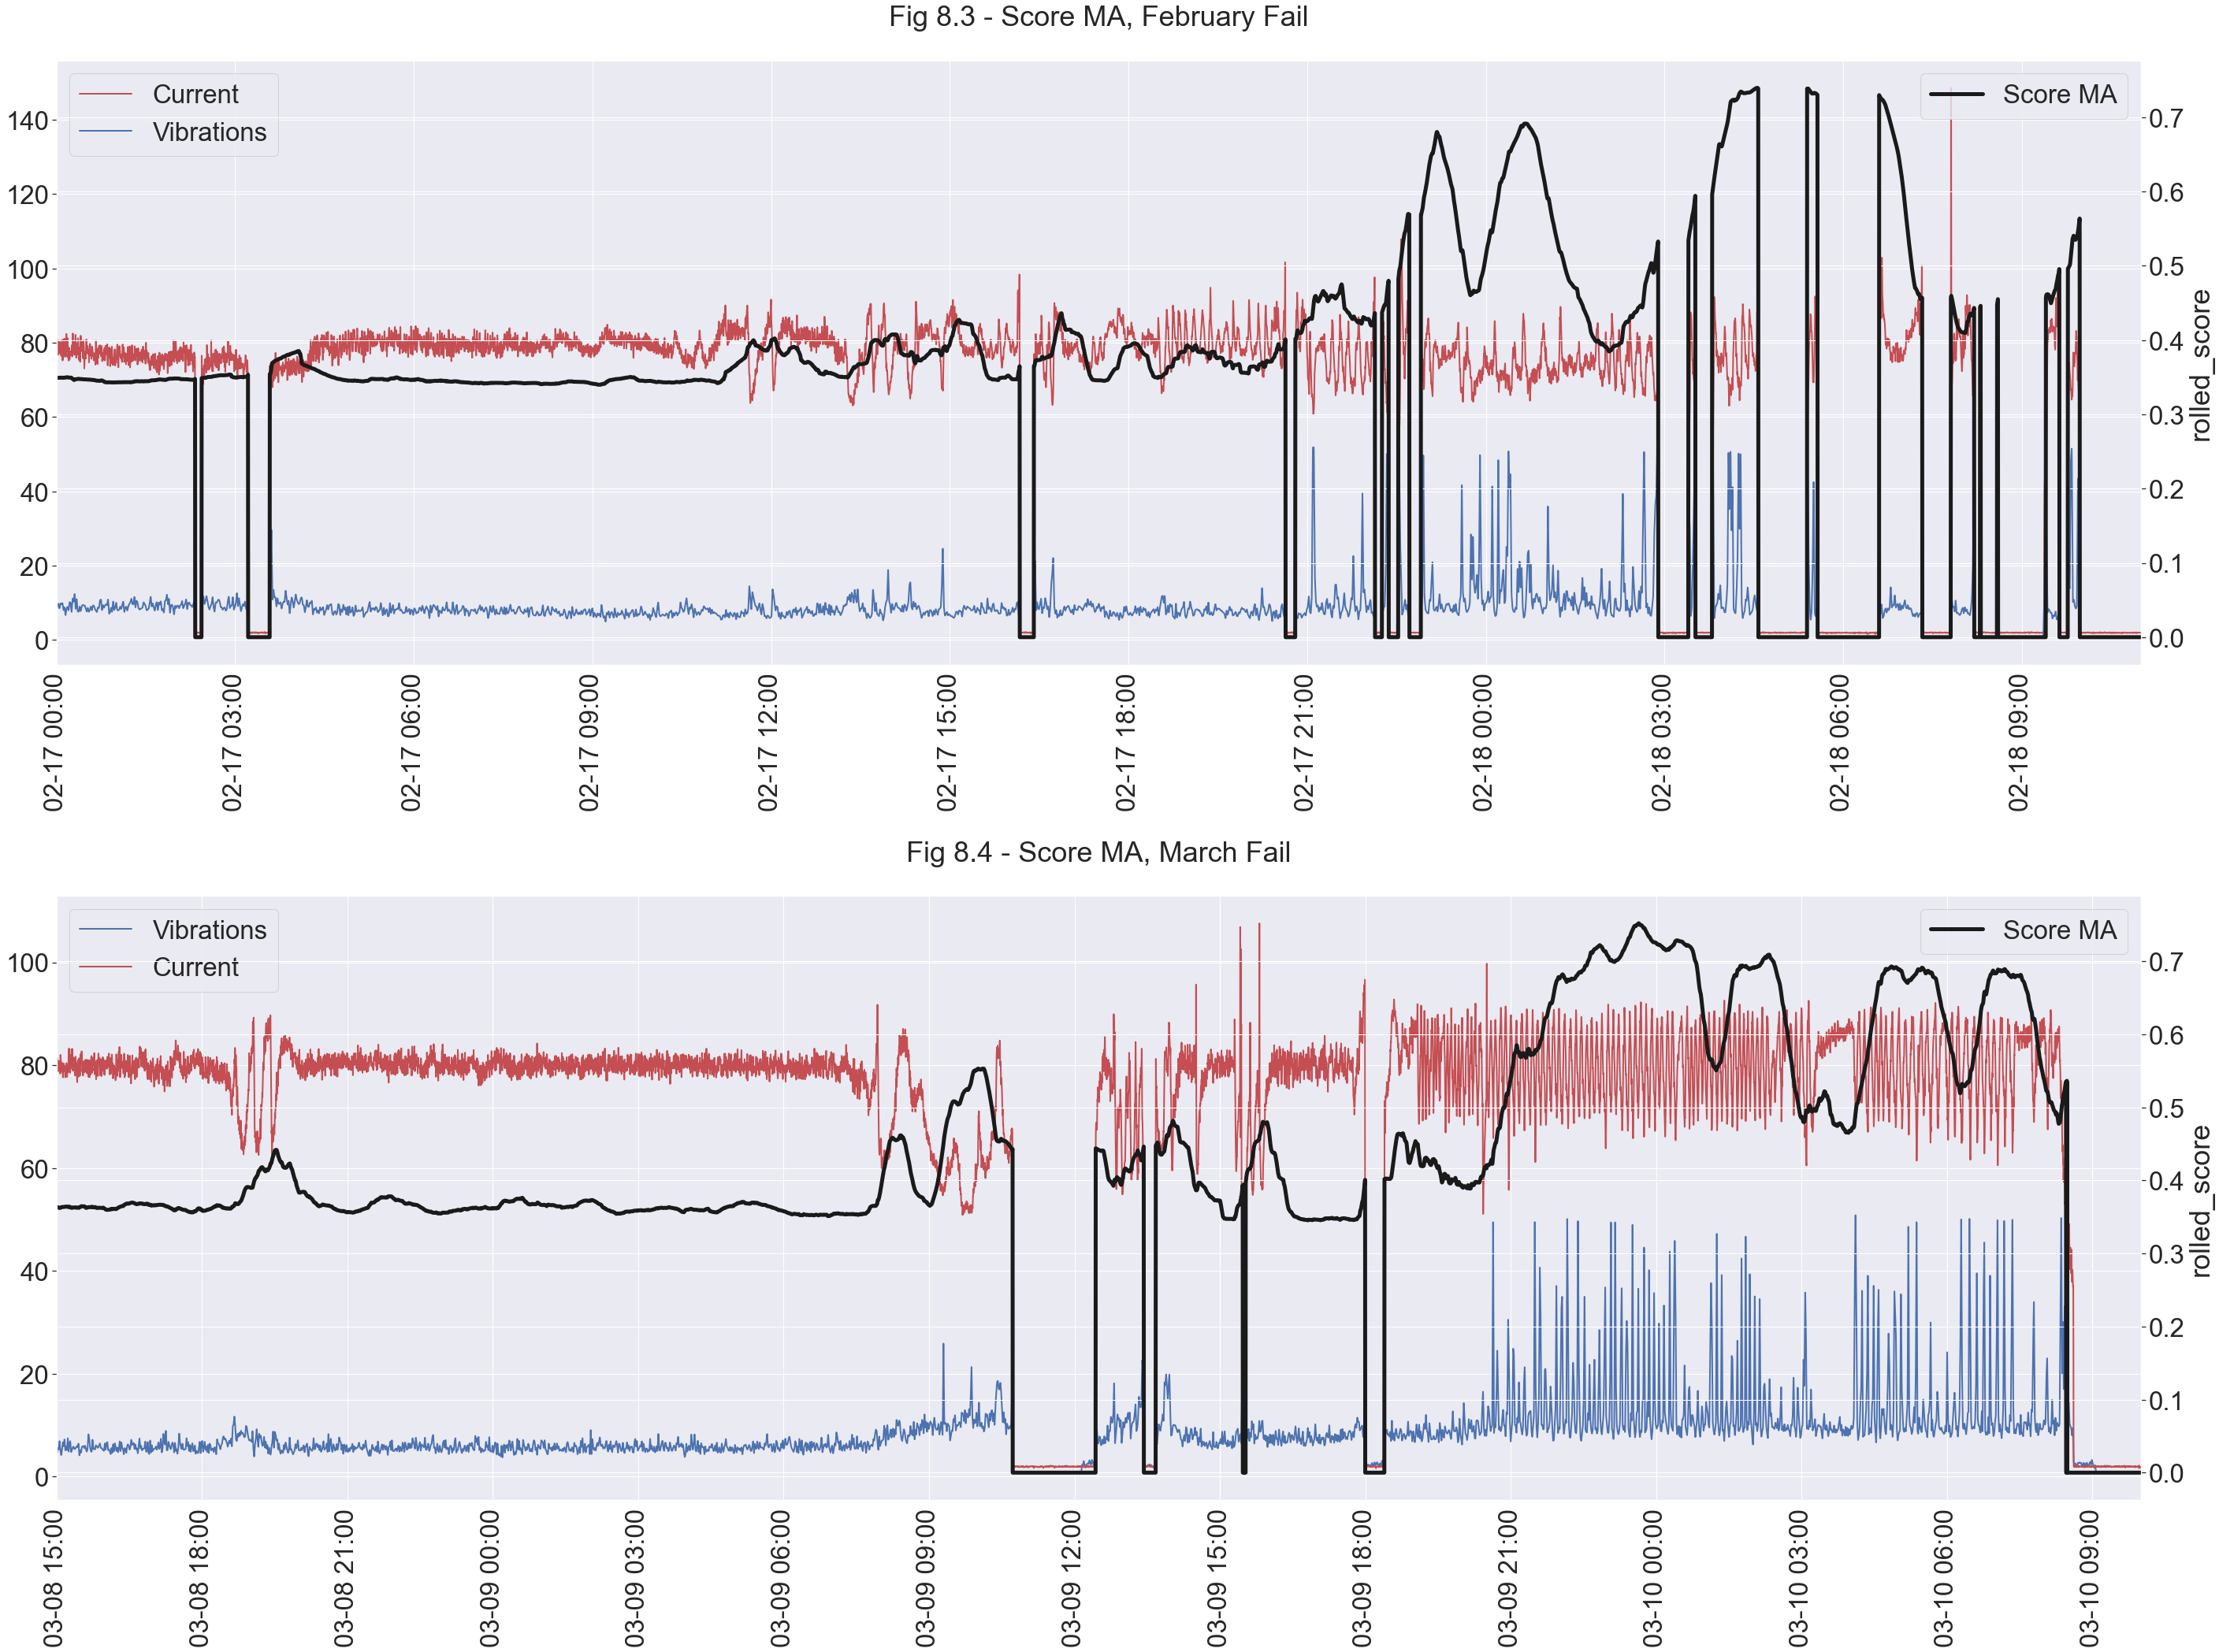

In [75]:
sns.set_theme(font_scale = 3) 

windw = 360

f = plt.figure(figsize=(40,30))

ax1 = f.add_subplot(211)
data_feb = data[(data['Date&Time'] >= '2022-02-17 00:00:00') & (data['Date&Time'] <= '2022-02-18 11:00:00')]

sns.lineplot(x = range(len(data_feb)), y = data_feb['Current'], label = 'Current', ax = ax1, color = 'r', lw = 2)
sns.lineplot(x = range(len(data_feb)), y = data_feb['Vibrations'], label = 'Vibrations', ax = ax1, color = 'b', lw = 2)
sns.lineplot(x = range(len(data_feb)), y = data_feb['rolled_score'],
                 label = 'Score MA', ax = ax1.twinx(), lw = 5, color = 'k')

ax1.set_xlim(0,len(data_feb))

loc, label = axis_label(data_feb)
ax1.set_xticks(loc, label, rotation = 90)

ax1.legend(loc = 'upper left');
ax1.set_title('Fig 8.3 - Score MA, February Fail', y = 1.05);
ax1.set_ylabel('')

ax2 = f.add_subplot(212)
data_mar = data[(data['Date&Time'] >= '2022-03-08 15:00:00') & (data['Date&Time'] <= '2022-03-10 10:00:00')]

sns.lineplot(x = range(len(data_mar)), y = data_mar['Vibrations'], label = 'Vibrations', ax = ax2, color = 'b', lw = 2)
sns.lineplot(x = range(len(data_mar)), y = data_mar['Current'], label = 'Current', ax = ax2, color = 'r', lw = 2)
sns.lineplot(x = range(len(data_mar)), y = data_mar['rolled_score'],
             label = 'Score MA', ax = ax2.twinx(), lw = 5, color = 'k')

ax2.set_xlim(0,len(data_mar))

loc, label = axis_label(data_mar)
ax2.set_xticks(loc, label, rotation = 90)

axis_label(data_mar)
ax2.legend(loc = 'upper left');
ax2.set_title('Fig 8.4 - Score MA, March Fail', y = 1.05);
ax2.set_ylabel('')

plt.tight_layout()

### 8.1 - Setting Alarm threshold

At this point a certain threshold should be set to generate an alarm.

In Fig 8.5 we can see how many alarms are generated over a 1-year period (y-axis), per alarm threshold (x-axis).
We are looking for a threshold that will detect February and March failure, but won't generate too many false alarms.

In [76]:
data_online = data[data['Current'] > 50].copy().reset_index(drop = True)

thresholds = np.arange(0.35, 0.8, 0.01)

sum_alarms = []

for threshold in tqdm(thresholds):
    
    alarms = pd.Series(np.where(data_online['rolled_score'] >= threshold, 1, 0), name = 'Alarms')

    df = pd.concat([data_online[['Date&Time', 'year', 'month', 'day']], alarms], axis = 1)
    sum_alarms.append(df.drop('Date&Time', axis = 1).groupby(['year', 'month', 'day']).max().sum()[0])

100%|██████████| 46/46 [00:26<00:00,  1.74it/s]


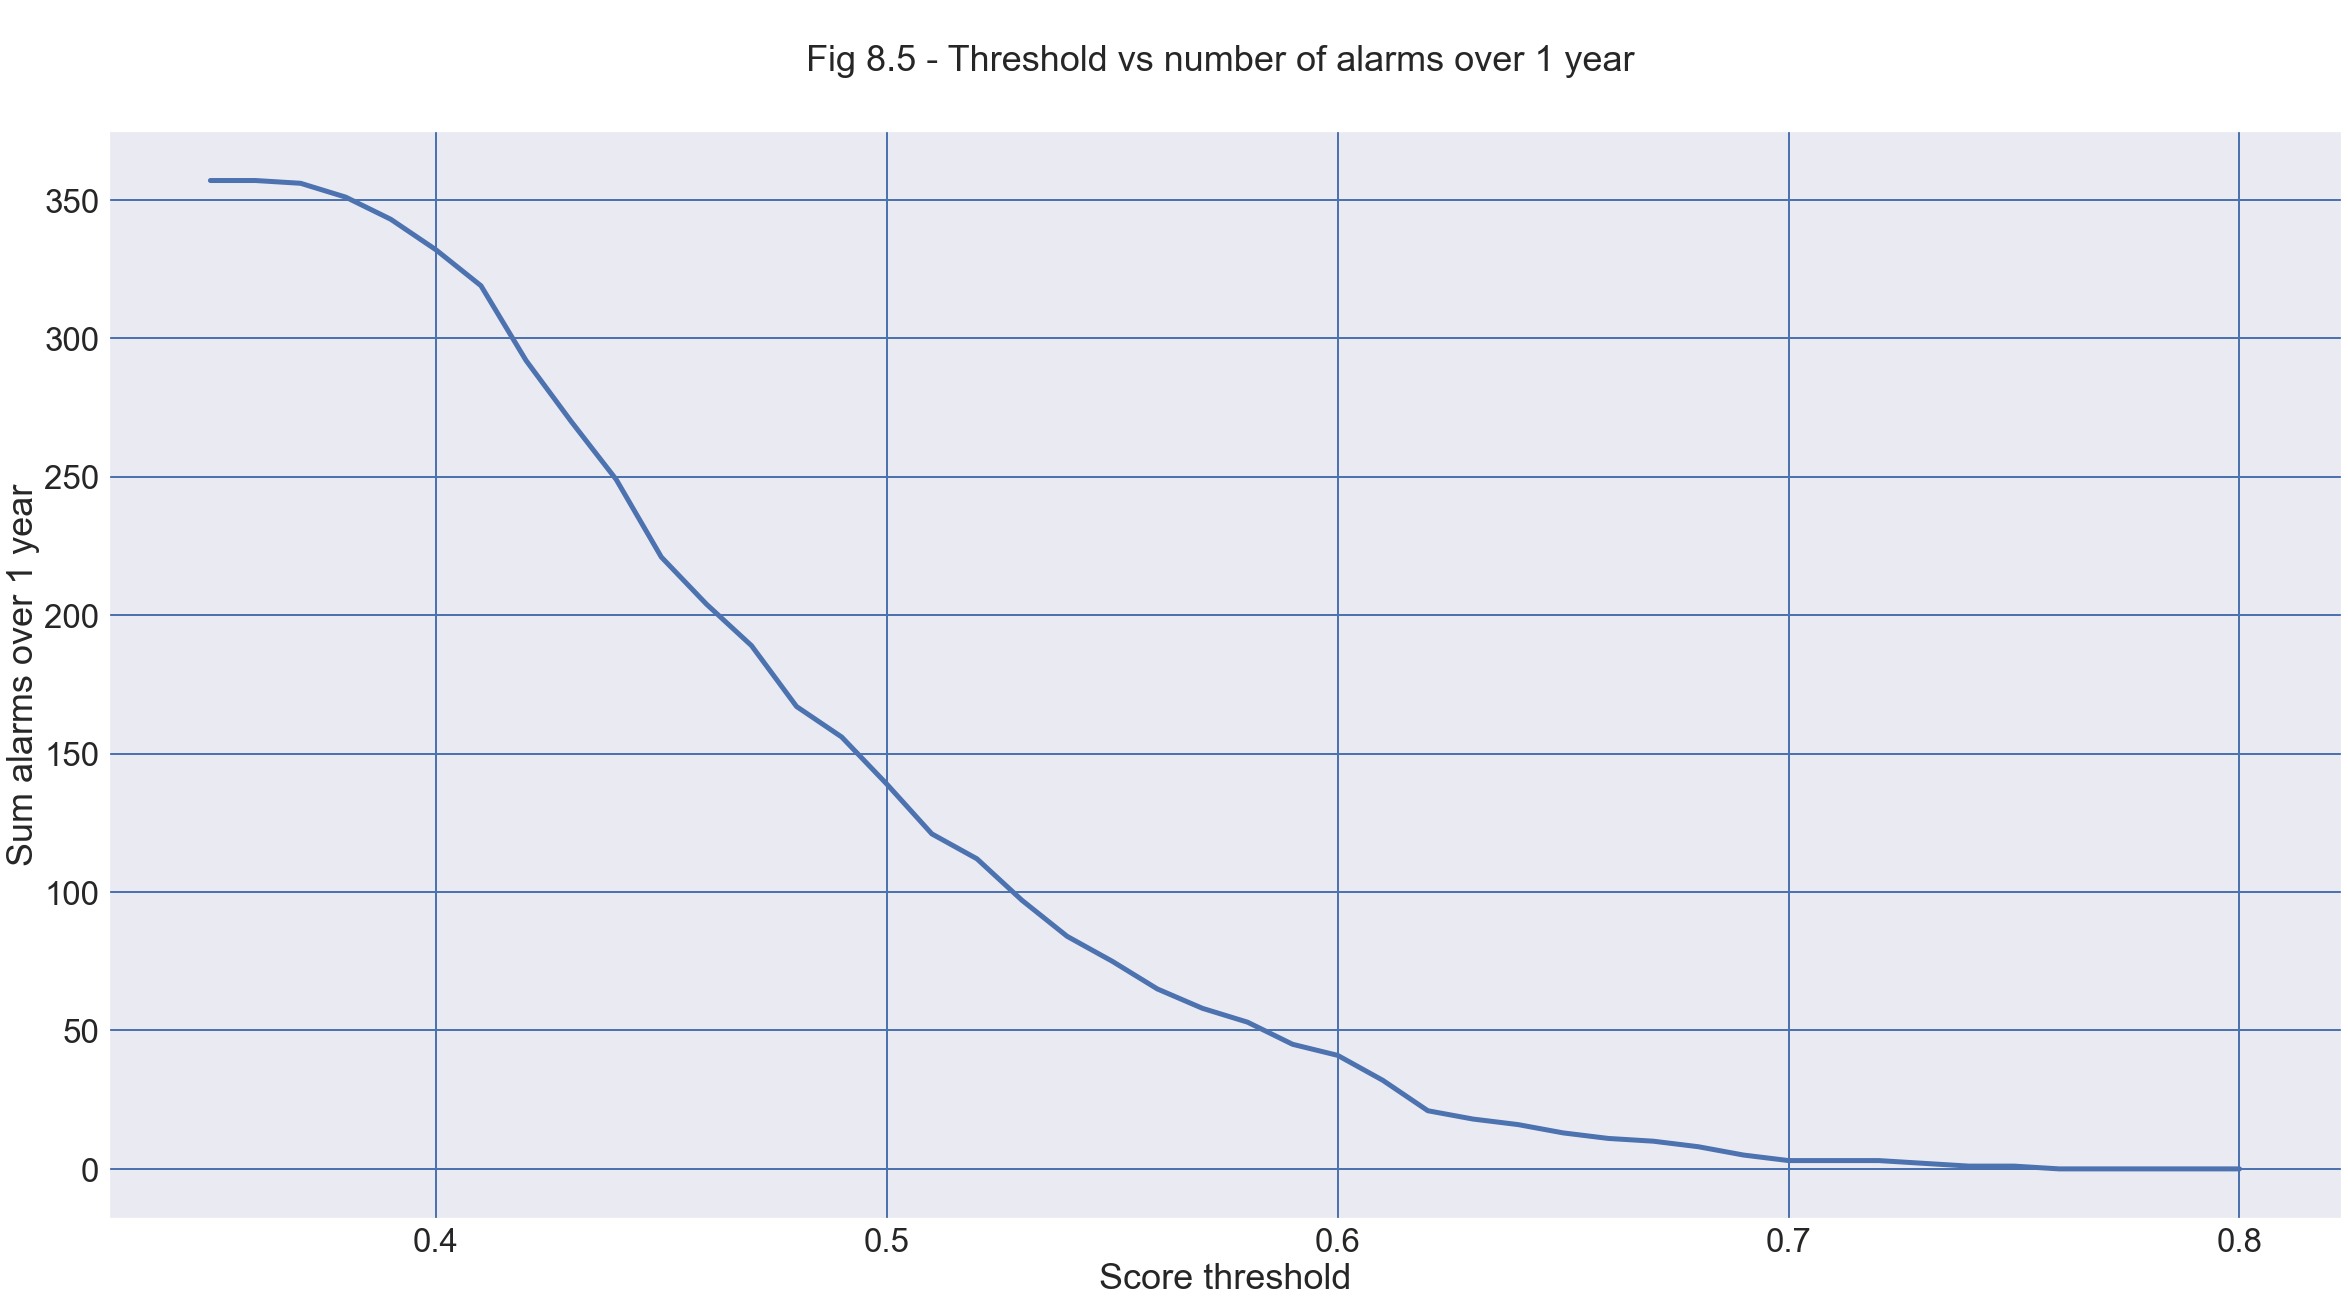

In [77]:
sns.set_theme(font_scale = 3) 

sns.lineplot(x = thresholds, y = sum_alarms, lw = 5);
plt.grid(linewidth=2, color = 'b')
plt.ylabel('Sum alarms over 1 year')
plt.xlabel('Score threshold');
plt.title('\nFig 8.5 - Threshold vs number of alarms over 1 year ', y = 1.05);

Fig 8.6 presents an event calendar. Y-axis denotes the day of month; X-axis denotes the month of year.

Red marks at least 1 event during that day, blue marks an eventless day.

Increasing MA score threshold was used in the sub plots, resulting in decreasing events.

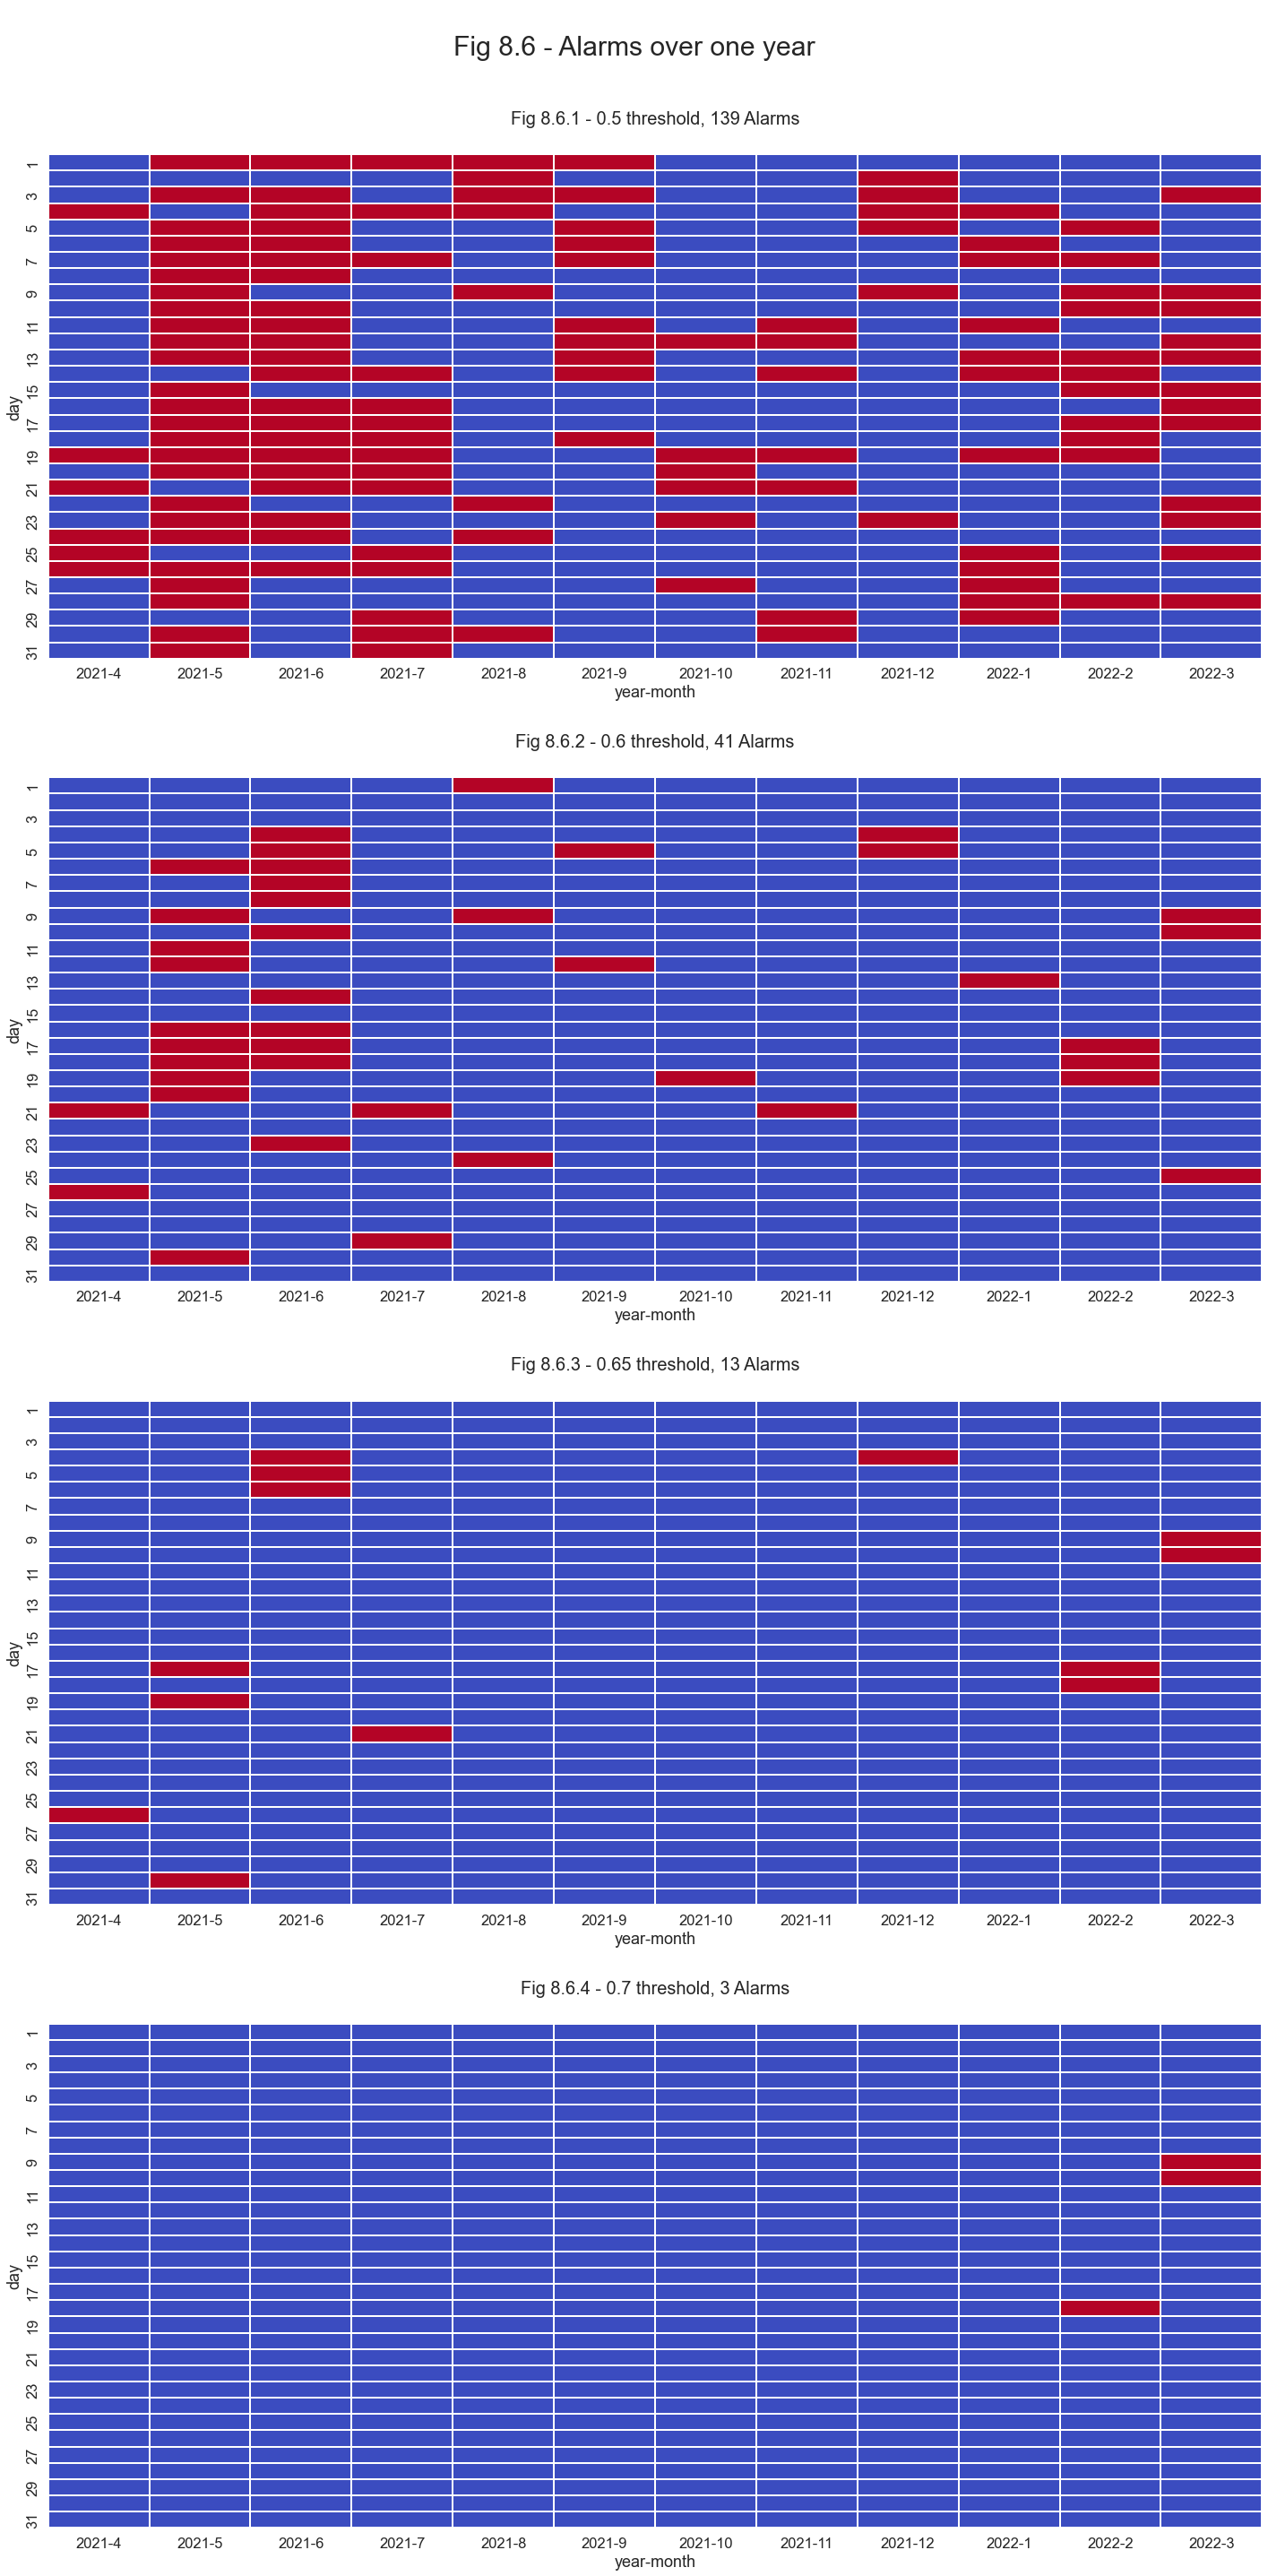

In [79]:
sns.set_theme(font_scale = 1.5) 

thresholds = [0.5, 0.6, 0.65, 0.7]

fig, ax = plt.subplots(len(thresholds), 1, figsize = (20,40))#, sharex = True)
plt.suptitle('\nFig 8.6 - Alarms over one year',fontsize=30, y = 1);

for i, threshold in enumerate(thresholds):
    
    alarms = pd.Series(np.where(data['rolled_score'] >= threshold, 1, 0), name = 'Alarms')
    df = pd.concat([data[['Date&Time', 'year', 'month', 'day']], alarms], axis = 1)
    
    df_pivot = pd.pivot_table(df, index = 'day', columns = ['year', 'month'], aggfunc = 'max', values = 'Alarms')
    df_pivot.fillna(0, inplace = True)
    
    sns.heatmap(df_pivot, cmap = 'coolwarm', linewidth = 2, cbar = False, ax = ax[i]);
    
    sum_alarms = int(df_pivot.sum().sum())
    ax[i].set_title(f'\nFig 8.6.{i+1} - {threshold} threshold, {sum_alarms} Alarms', y = 1.05, fontdict = {'fontsize': 20})
    
plt.tight_layout()

0.7 Threshold (fig 8.6.4) leaves only 3 alarms at the known two failures:

1. 9-10.3.2022 - Both days were marked.
2. 18.2.2022 - Only 1 day was marked.

Although it seems like the best threshold, it might be too high for future failure detection, especially since the 18th of February was not marked in red. We rather generate additional false positives and risk missing a lower score true positive.

0.65 threshold generates 13 detections (fig 8.6.3) over the course of 1 year. This is an acceptable "False alarm" number (Recall second goal of the project).

# 9. Conclusions:

1. Overall - Results looks quite satisfying.


2. Extended Isolation Forest has proved to be an efficient algorithm for failure detection, even though further actions were required to improve the overall result.


# 10. Future improvements

1. Power ups - On power up, the raw material is being fed at a slow rate, gradually increasing up to full capacity. This causes high vibration readings and current fluctuations. This phenomenon generates noise that should be filtered out. This in turn will allow to further reduce the score MA threshold, while maintaining an acceptable false positive count.

2. The vibration sensor is only one dimensional, making it difficult to get stable readings - if a vibration accrued vertical to the sensor's plane, the reading will be 0. Installing an additional sensor, at 90 deg from the current one, has a good potential of further improving the quality of the vibration signal.


3. Further investigation of EIF hyperparameter - extension level range from 1 to number of features-1. This hyperparameter was left at its maximum default value.


4. Signal processing and analysis theorem offer a large variety of tools such as low/high pass filters, FIR, IIR and so on. Extracting features using those tools could also have added value.


5. Investigating the other 10 false alarms that were generated with 0.65 threshold.

# 11. Summery

This project has great potential in detecting future failures, which can result in a dramatic reduction in downtime and increase of production on an annual basis.

Furthermore - Although the implementation was on pendulum mills, it can be **implemented on any type of rotating equipment** with at least vibrations and current monitoring.

This is because most rotating equipment operate at a "steady-state" mode - constant speed, feed/flow rate, external loads, etc. Signals from steady-state equipment tend to have narrow gaussian distribution, with some skewness towards higher values, which represent failure anomalies. This kind of data distribution is perfect for isolation forest detection.